In [1]:
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.data import Dataset
from matplotlib import pyplot
from tensorflow.keras.callbacks import TensorBoard
import numpy as np

2021-10-21 13:11:26.090671: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-21 13:11:26.090707: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
path =r'../data/datasets_by_whale/'
filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    df = pd.read_csv(filename).drop(columns=["Unnamed: 0", "individual-local-identifier", "year", "month"])
    if df.shape > (40,):
        dfs.append(df)

In [3]:
df

,location-long,location-lat
0,-96.698,8.794
1,-96.577,8.746
2,-96.623,9.087
3,-96.712,9.110
4,-96.810,8.989
...,...,...
316,-115.027,26.702
317,-115.930,26.972
318,-119.121,30.734
319,-119.172,30.742


In [4]:
def split_data(df):

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    num_features = df.shape[1]
    
    return train_df, val_df,test_df

In [5]:
split_data_result = [split_data(df) for df in dfs]

In [6]:
def data_windowing(train_df,val_df,test_df):
    n_points = 20
    window_length = n_points+ 1 
    
    window_train = tf.keras.utils.timeseries_dataset_from_array(
    train_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    
    window_test = tf.keras.utils.timeseries_dataset_from_array(
    test_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
        
    window_val = tf.keras.utils.timeseries_dataset_from_array(
    val_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    
    return window_train, window_test, window_val

In [7]:
def data_map(elem):
    n_points = 20
    window_length = n_points+ 1 
    X,y = elem[:,:-1,:],elem[:,-1:,0:2]
    X.set_shape([None, n_points, None])
    y.set_shape([None, window_length - n_points, None])
    
    return X,y


In [8]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=2)
])

2021-10-21 13:11:28.207323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-21 13:11:28.207367: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-21 13:11:28.207383: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-R3AGIN3): /proc/driver/nvidia/version does not exist
2021-10-21 13:11:28.207914: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError()])

In [10]:
hist_df = pd.DataFrame(columns=["loss", "val_loss", "mean_absolute_error", "val_mean_absolute_error"])
for i, (train_df,val_df,test_df) in enumerate(split_data_result):
    
    #print(i,len(split_data_result))
    
    window_train,window_val,window_test = data_windowing(train_df,val_df,test_df)
    train = window_train.map(data_map)
    test = window_test.map(data_map)
    val = window_val.map(data_map)
    
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=5,
                                                    mode='min')
    
    tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=2)
    
    history = lstm_model.fit(train, epochs=20,
                             validation_data=val,
                             callbacks=[tensorboard_callback])
    
    history_step = []
    
    for i in range(len(history.history["loss"])):
        history_step.append({
            "loss": history.history["loss"][i],
            "mean_absolute_error": history.history["mean_absolute_error"][i],
            "val_loss": history.history.get("val_loss", [np.nan for _ in range(i+1)])[i],
            "val_mean_absolute_error": history.history.get("val_mean_absolute_error", [np.nan for _ in range(i+1)])[i]
            
        })
    
    hist_df = hist_df.append(pd.DataFrame(history_step))


2021-10-21 13:11:29.419812: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:29.419864: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:29.419919: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:29.440335: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
2/2 [==============================] - 2s 200ms/step - loss: 7523.1743 - mean_absolute_error: 75.5642


2021-10-21 13:11:30.849989: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:30.850034: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:30.867759: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:30.873893: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:30.904623: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_30

2021-10-21 13:11:30.920314: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_30/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:11:30.933346: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_30

2021-10-21 13:11:30.

Epoch 2/20
2/2 [==============================] - 0s 65ms/step - loss: 7517.2563 - mean_absolute_error: 75.5392
Epoch 3/20
2/2 [==============================] - 0s 57ms/step - loss: 7511.7544 - mean_absolute_error: 75.5152
Epoch 4/20
2/2 [==============================] - 0s 50ms/step - loss: 7506.5859 - mean_absolute_error: 75.4927
Epoch 5/20
2/2 [==============================] - 0s 51ms/step - loss: 7501.6118 - mean_absolute_error: 75.4715
Epoch 6/20
2/2 [==============================] - 0s 59ms/step - loss: 7496.6328 - mean_absolute_error: 75.4515
Epoch 7/20
2/2 [==============================] - 0s 51ms/step - loss: 7491.3838 - mean_absolute_error: 75.4325
Epoch 8/20
2/2 [==============================] - 0s 56ms/step - loss: 7485.5449 - mean_absolute_error: 75.4140
Epoch 9/20
2/2 [==============================] - 0s 54ms/step - loss: 7478.7427 - mean_absolute_error: 75.3958
Epoch 10/20
2/2 [==============================] - 0s 52ms/step - loss: 7470.7007 - mean_absolute_error:

2021-10-21 13:11:33.009078: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:33.009117: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:33.009150: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:33.208953: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:33.208994: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 122ms/step - loss: 7717.8877 - mean_absolute_error: 77.1130
Epoch 3/20
1/1 [==============================] - 0s 51ms/step - loss: 7711.6416 - mean_absolute_error: 77.0843


2021-10-21 13:11:33.225533: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:33.228629: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:33.252186: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_33

2021-10-21 13:11:33.260788: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_33/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:11:33.270313: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_33

2021-10-21 13:11:33.274145: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_33/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:1

Epoch 4/20
1/1 [==============================] - 0s 57ms/step - loss: 7704.9233 - mean_absolute_error: 77.0536
Epoch 5/20
1/1 [==============================] - 0s 55ms/step - loss: 7697.7305 - mean_absolute_error: 77.0211
Epoch 6/20
1/1 [==============================] - 0s 52ms/step - loss: 7690.0938 - mean_absolute_error: 76.9870
Epoch 7/20
1/1 [==============================] - 0s 54ms/step - loss: 7682.0869 - mean_absolute_error: 76.9520
Epoch 8/20
1/1 [==============================] - 0s 52ms/step - loss: 7673.8188 - mean_absolute_error: 76.9165
Epoch 9/20
1/1 [==============================] - 0s 52ms/step - loss: 7665.4204 - mean_absolute_error: 76.8813
Epoch 10/20
1/1 [==============================] - 0s 53ms/step - loss: 7657.0420 - mean_absolute_error: 76.8471
Epoch 11/20
1/1 [==============================] - 0s 53ms/step - loss: 7648.8252 - mean_absolute_error: 76.8142
Epoch 12/20
1/1 [==============================] - 0s 52ms/step - loss: 7640.9014 - mean_absolute_erro

2021-10-21 13:11:34.921461: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:34.921512: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:34.921545: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:35.102996: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:35.103035: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:35.118730: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:35.121716: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 117ms/step - loss: 7695.1860 - mean_absolute_error: 76.9256
Epoch 3/20
1/1 [==============================] - 0s 51ms/step - loss: 7691.6626 - mean_absolute_error: 76.9071
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 7688.1704 - mean_absolute_error: 76.8884

2021-10-21 13:11:35.145613: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_35

2021-10-21 13:11:35.154371: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_35/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:11:35.161134: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_35

2021-10-21 13:11:35.164986: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_35/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:11:35.183287: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_35
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_21_13_11_35/DE

1/1 [==============================] - 0s 56ms/step - loss: 7688.1704 - mean_absolute_error: 76.8884
Epoch 5/20
1/1 [==============================] - 0s 57ms/step - loss: 7684.6357 - mean_absolute_error: 76.8691
Epoch 6/20
1/1 [==============================] - 0s 56ms/step - loss: 7680.9907 - mean_absolute_error: 76.8492
Epoch 7/20
1/1 [==============================] - 0s 58ms/step - loss: 7677.1680 - mean_absolute_error: 76.8283
Epoch 8/20
1/1 [==============================] - 0s 56ms/step - loss: 7673.1118 - mean_absolute_error: 76.8062
Epoch 9/20
1/1 [==============================] - 0s 58ms/step - loss: 7668.7773 - mean_absolute_error: 76.7827
Epoch 10/20
1/1 [==============================] - 0s 56ms/step - loss: 7664.1392 - mean_absolute_error: 76.7578
Epoch 11/20
1/1 [==============================] - 0s 58ms/step - loss: 7659.1982 - mean_absolute_error: 76.7316
Epoch 12/20
1/1 [==============================] - 0s 53ms/step - loss: 7653.9985 - mean_absolute_error: 76.7041


2021-10-21 13:11:36.907847: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:36.907893: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:36.907926: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:37.087984: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:37.088022: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:37.104677: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:37.107445: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 134ms/step - loss: 6974.7881 - mean_absolute_error: 72.4858
Epoch 3/20
1/1 [==============================] - 0s 71ms/step - loss: 6969.6831 - mean_absolute_error: 72.4552


2021-10-21 13:11:37.129302: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_37

2021-10-21 13:11:37.138878: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_37/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:11:37.147549: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_37

2021-10-21 13:11:37.152751: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_37/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:11:37.173091: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_37
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_21_13_11_37/DE

Epoch 4/20
1/1 [==============================] - 0s 61ms/step - loss: 6964.2100 - mean_absolute_error: 72.4221
Epoch 5/20
1/1 [==============================] - 0s 57ms/step - loss: 6958.2505 - mean_absolute_error: 72.3857
Epoch 6/20
1/1 [==============================] - 0s 53ms/step - loss: 6951.7163 - mean_absolute_error: 72.3455
Epoch 7/20
1/1 [==============================] - 0s 59ms/step - loss: 6944.5771 - mean_absolute_error: 72.3012
Epoch 8/20
1/1 [==============================] - 0s 58ms/step - loss: 6936.8789 - mean_absolute_error: 72.2531
Epoch 9/20
1/1 [==============================] - 0s 61ms/step - loss: 6928.7588 - mean_absolute_error: 72.2021
Epoch 10/20
1/1 [==============================] - 0s 53ms/step - loss: 6920.4321 - mean_absolute_error: 72.1495
Epoch 11/20
1/1 [==============================] - 0s 56ms/step - loss: 6912.1597 - mean_absolute_error: 72.0972
Epoch 12/20
1/1 [==============================] - 0s 53ms/step - loss: 6904.1860 - mean_absolute_erro

2021-10-21 13:11:38.871149: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:38.871193: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:38.871226: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:38.970906: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:38.970949: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:38.983764: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:38.985417: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:39.003749: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_38

2021-10-21 13:11:39.008658: I tensorflow/core/profil

3/3 [==============================] - 0s 81ms/step - loss: 6826.9272 - mean_absolute_error: 71.8879
Epoch 2/20
3/3 [==============================] - 0s 30ms/step - loss: 6801.0391 - mean_absolute_error: 71.7333
Epoch 3/20
3/3 [==============================] - 0s 30ms/step - loss: 6783.3921 - mean_absolute_error: 71.6232
Epoch 4/20
3/3 [==============================] - 0s 28ms/step - loss: 6774.3022 - mean_absolute_error: 71.5636
Epoch 5/20
3/3 [==============================] - 0s 30ms/step - loss: 6764.5576 - mean_absolute_error: 71.5035
Epoch 6/20
3/3 [==============================] - 0s 28ms/step - loss: 6752.5391 - mean_absolute_error: 71.4358
Epoch 7/20
3/3 [==============================] - 0s 30ms/step - loss: 6738.8530 - mean_absolute_error: 71.3642
Epoch 8/20
3/3 [==============================] - 0s 31ms/step - loss: 6723.4805 - mean_absolute_error: 71.2934
Epoch 9/20
3/3 [==============================] - 0s 32ms/step - loss: 6702.7983 - mean_absolute_error: 71.2063
Epo

2021-10-21 13:11:41.131644: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:41.131688: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:41.131721: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:41.310362: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:41.310400: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:41.325565: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:41.328125: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 118ms/step - loss: 7133.8296 - mean_absolute_error: 73.5857
Epoch 3/20
1/1 [==============================] - 0s 51ms/step - loss: 7130.7544 - mean_absolute_error: 73.5640


2021-10-21 13:11:41.350839: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_41

2021-10-21 13:11:41.359917: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_41/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:11:41.367644: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_41

2021-10-21 13:11:41.374262: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_41/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:11:41.391716: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_41
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_21_13_11_41/DE

Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 7127.7036 - mean_absolute_error: 73.5422
Epoch 5/20
1/1 [==============================] - 0s 59ms/step - loss: 7124.6104 - mean_absolute_error: 73.5197
Epoch 6/20
1/1 [==============================] - 0s 52ms/step - loss: 7121.4478 - mean_absolute_error: 73.4960
Epoch 7/20
1/1 [==============================] - 0s 60ms/step - loss: 7118.1807 - mean_absolute_error: 73.4705
Epoch 8/20
1/1 [==============================] - 0s 54ms/step - loss: 7114.7729 - mean_absolute_error: 73.4427
Epoch 9/20
1/1 [==============================] - 0s 55ms/step - loss: 7111.1782 - mean_absolute_error: 73.4118
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 7107.3481 - mean_absolute_error: 73.3772
Epoch 11/20
1/1 [==============================] - 0s 54ms/step - loss: 7103.2529 - mean_absolute_error: 73.3386
Epoch 12/20
1/1 [==============================] - 0s 53ms/step - loss: 7098.9033 - mean_absolute_erro

2021-10-21 13:11:43.029752: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:43.029794: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:43.029826: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:43.134658: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:43.134702: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:43.147614: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:43.149458: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:43.169541: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_43

2021-10-21 13:11:43.175280: I tensorflow/core/profil

3/3 [==============================] - 0s 83ms/step - loss: 6360.1592 - mean_absolute_error: 67.8459
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 6350.8877 - mean_absolute_error: 67.7749
Epoch 3/20
3/3 [==============================] - 0s 30ms/step - loss: 6341.9072 - mean_absolute_error: 67.7085
Epoch 4/20
3/3 [==============================] - 0s 29ms/step - loss: 6332.9824 - mean_absolute_error: 67.6442
Epoch 5/20
3/3 [==============================] - 0s 29ms/step - loss: 6323.7212 - mean_absolute_error: 67.5797
Epoch 6/20
3/3 [==============================] - 0s 30ms/step - loss: 6313.2207 - mean_absolute_error: 67.5108
Epoch 7/20
3/3 [==============================] - 0s 30ms/step - loss: 6300.1006 - mean_absolute_error: 67.4309
Epoch 8/20
3/3 [==============================] - 0s 31ms/step - loss: 6284.7495 - mean_absolute_error: 67.3394
Epoch 9/20
3/3 [==============================] - 0s 31ms/step - loss: 6271.0229 - mean_absolute_error: 67.2531
Epo

2021-10-21 13:11:45.278182: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:45.278241: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:45.278274: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:45.388605: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:45.388647: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:45.399460: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:45.400875: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:45.418521: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_45

2021-10-21 13:11:45.423298: I tensorflow/core/profil

2/2 [==============================] - 0s 157ms/step - loss: 7093.4312 - mean_absolute_error: 73.8863
Epoch 2/20
2/2 [==============================] - 0s 49ms/step - loss: 7083.0898 - mean_absolute_error: 73.8227
Epoch 3/20
2/2 [==============================] - 0s 49ms/step - loss: 7072.9390 - mean_absolute_error: 73.7587
Epoch 4/20
2/2 [==============================] - 0s 50ms/step - loss: 7065.6890 - mean_absolute_error: 73.7101
Epoch 5/20
2/2 [==============================] - 0s 50ms/step - loss: 7059.0942 - mean_absolute_error: 73.6650
Epoch 6/20
2/2 [==============================] - 0s 49ms/step - loss: 7052.4702 - mean_absolute_error: 73.6194
Epoch 7/20
2/2 [==============================] - 0s 51ms/step - loss: 7045.8247 - mean_absolute_error: 73.5734
Epoch 8/20
2/2 [==============================] - 0s 50ms/step - loss: 7039.1689 - mean_absolute_error: 73.5273
Epoch 9/20
2/2 [==============================] - 0s 54ms/step - loss: 7032.5166 - mean_absolute_error: 73.4810
Ep

2021-10-21 13:11:47.394469: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:47.394514: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:47.394546: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:47.581070: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:47.581109: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 123ms/step - loss: 6550.2056 - mean_absolute_error: 69.7245
Epoch 3/20
1/1 [==============================] - 0s 55ms/step - loss: 6547.1763 - mean_absolute_error: 69.7023


2021-10-21 13:11:47.600683: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:47.604453: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:47.627388: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_47

2021-10-21 13:11:47.636813: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_47/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:11:47.645769: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_47

2021-10-21 13:11:47.649108: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_47/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:1

Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 6544.1616 - mean_absolute_error: 69.6803
Epoch 5/20
1/1 [==============================] - 0s 54ms/step - loss: 6541.1597 - mean_absolute_error: 69.6585
Epoch 6/20
1/1 [==============================] - 0s 56ms/step - loss: 6538.1704 - mean_absolute_error: 69.6367
Epoch 7/20
1/1 [==============================] - 0s 59ms/step - loss: 6535.1953 - mean_absolute_error: 69.6151
Epoch 8/20
1/1 [==============================] - 0s 53ms/step - loss: 6532.2300 - mean_absolute_error: 69.5936
Epoch 9/20
1/1 [==============================] - 0s 59ms/step - loss: 6529.2754 - mean_absolute_error: 69.5722
Epoch 10/20
1/1 [==============================] - 0s 54ms/step - loss: 6526.3315 - mean_absolute_error: 69.5509
Epoch 11/20
1/1 [==============================] - 0s 60ms/step - loss: 6523.3960 - mean_absolute_error: 69.5296
Epoch 12/20
1/1 [==============================] - 0s 54ms/step - loss: 6520.4702 - mean_absolute_erro

2021-10-21 13:11:49.350688: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:49.350730: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:49.350762: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:49.456560: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:49.456605: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:49.473696: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:49.476195: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:49.495844: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_49

2021-10-21 13:11:49.502313: I tensorflow/core/profil

4/4 [==============================] - 0s 59ms/step - loss: 6241.5190 - mean_absolute_error: 67.6106
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 6230.5791 - mean_absolute_error: 67.5298
Epoch 3/20
4/4 [==============================] - 0s 23ms/step - loss: 6219.8184 - mean_absolute_error: 67.4511
Epoch 4/20
4/4 [==============================] - 0s 22ms/step - loss: 6209.1890 - mean_absolute_error: 67.3736
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 6198.6631 - mean_absolute_error: 67.2972
Epoch 6/20
4/4 [==============================] - 0s 25ms/step - loss: 6188.2173 - mean_absolute_error: 67.2215
Epoch 7/20
4/4 [==============================] - 0s 24ms/step - loss: 6177.8398 - mean_absolute_error: 67.1463
Epoch 8/20
4/4 [==============================] - 0s 23ms/step - loss: 6167.5200 - mean_absolute_error: 67.0716
Epoch 9/20
4/4 [==============================] - 0s 23ms/step - loss: 6157.2529 - mean_absolute_error: 66.9972
Epo

2021-10-21 13:11:51.833820: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:51.833864: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:51.833897: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:51.933654: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:51.933698: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:51.946917: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:51.948471: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:51.966628: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_51

2021-10-21 13:11:51.971987: I tensorflow/core/profil

4/4 [==============================] - 0s 55ms/step - loss: 7027.1943 - mean_absolute_error: 73.2085
Epoch 2/20
4/4 [==============================] - 0s 22ms/step - loss: 7016.0190 - mean_absolute_error: 73.1334
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 7004.6133 - mean_absolute_error: 73.0557
Epoch 4/20
4/4 [==============================] - 0s 22ms/step - loss: 6993.0732 - mean_absolute_error: 72.9764
Epoch 5/20
4/4 [==============================] - 0s 22ms/step - loss: 6981.4653 - mean_absolute_error: 72.8963
Epoch 6/20
4/4 [==============================] - 0s 22ms/step - loss: 6969.8291 - mean_absolute_error: 72.8156
Epoch 7/20
4/4 [==============================] - 0s 23ms/step - loss: 6958.1924 - mean_absolute_error: 72.7347
Epoch 8/20
4/4 [==============================] - 0s 23ms/step - loss: 6946.5723 - mean_absolute_error: 72.6538
Epoch 9/20
4/4 [==============================] - 0s 22ms/step - loss: 6934.9785 - mean_absolute_error: 72.5730
Epo

2021-10-21 13:11:54.225173: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:54.225217: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:54.225249: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:54.325927: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:54.325970: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:54.337950: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:54.339423: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:54.361717: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_54

2021-10-21 13:11:54.370493: I tensorflow/core/profil

5/5 [==============================] - 0s 114ms/step - loss: 6192.5796 - mean_absolute_error: 67.2323 - val_loss: 3454.4663 - val_mean_absolute_error: 42.4532
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 6179.7988 - mean_absolute_error: 67.1377 - val_loss: 3446.4185 - val_mean_absolute_error: 42.3596
Epoch 3/20
5/5 [==============================] - 0s 20ms/step - loss: 6167.1885 - mean_absolute_error: 67.0446 - val_loss: 3438.4463 - val_mean_absolute_error: 42.2671
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 6154.6938 - mean_absolute_error: 66.9524 - val_loss: 3430.5308 - val_mean_absolute_error: 42.1754
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 6142.2852 - mean_absolute_error: 66.8609 - val_loss: 3422.6609 - val_mean_absolute_error: 42.0842
Epoch 6/20
5/5 [==============================] - 0s 20ms/step - loss: 6129.9438 - mean_absolute_error: 66.7700 - val_loss: 3414.8296 - val_mean_absolute_error: 41.9

2021-10-21 13:11:57.242617: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:57.242661: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:57.242694: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:57.423129: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:57.423169: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 0s 138ms/step - loss: 6099.1279 - mean_absolute_error: 66.1180
Epoch 3/20
1/1 [==============================] - 0s 58ms/step - loss: 6096.6895 - mean_absolute_error: 66.1000


2021-10-21 13:11:57.454981: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:57.457787: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:57.485594: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_57

2021-10-21 13:11:57.495147: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_57/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:11:57.502468: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_57

2021-10-21 13:11:57.505047: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_11_57/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:1

Epoch 4/20
1/1 [==============================] - 0s 56ms/step - loss: 6094.2505 - mean_absolute_error: 66.0821
Epoch 5/20
1/1 [==============================] - 0s 55ms/step - loss: 6091.8105 - mean_absolute_error: 66.0641
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 6089.3677 - mean_absolute_error: 66.0461
Epoch 7/20
1/1 [==============================] - 0s 55ms/step - loss: 6086.9263 - mean_absolute_error: 66.0282
Epoch 8/20
1/1 [==============================] - 0s 54ms/step - loss: 6084.4839 - mean_absolute_error: 66.0102
Epoch 9/20
1/1 [==============================] - 0s 59ms/step - loss: 6082.0425 - mean_absolute_error: 65.9922
Epoch 10/20
1/1 [==============================] - 0s 56ms/step - loss: 6079.6011 - mean_absolute_error: 65.9742
Epoch 11/20
1/1 [==============================] - 0s 54ms/step - loss: 6077.1582 - mean_absolute_error: 65.9562
Epoch 12/20
1/1 [==============================] - 0s 54ms/step - loss: 6074.7168 - mean_absolute_erro

2021-10-21 13:11:59.214321: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:59.214365: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:59.214398: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:59.320387: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:11:59.320430: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:11:59.334203: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:11:59.335769: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:11:59.353238: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_11_59

2021-10-21 13:11:59.358266: I tensorflow/core/profil

3/3 [==============================] - 0s 80ms/step - loss: 5689.8770 - mean_absolute_error: 63.4796
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 5682.9639 - mean_absolute_error: 63.4268
Epoch 3/20
3/3 [==============================] - 0s 30ms/step - loss: 5676.1626 - mean_absolute_error: 63.3754
Epoch 4/20
3/3 [==============================] - 0s 28ms/step - loss: 5669.4463 - mean_absolute_error: 63.3250
Epoch 5/20
3/3 [==============================] - 0s 29ms/step - loss: 5662.7935 - mean_absolute_error: 63.2753
Epoch 6/20
3/3 [==============================] - 0s 31ms/step - loss: 5656.1895 - mean_absolute_error: 63.2263
Epoch 7/20
3/3 [==============================] - 0s 30ms/step - loss: 5649.6245 - mean_absolute_error: 63.1776
Epoch 8/20
3/3 [==============================] - 0s 29ms/step - loss: 5643.0874 - mean_absolute_error: 63.1292
Epoch 9/20
3/3 [==============================] - 0s 30ms/step - loss: 5636.5747 - mean_absolute_error: 63.0811
Epo

2021-10-21 13:12:01.475440: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:01.475484: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:01.475517: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:01.585617: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:01.585660: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:01.596738: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:01.598173: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:01.613718: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_01

2021-10-21 13:12:01.617933: I tensorflow/core/profil

6/6 [==============================] - 0s 39ms/step - loss: 4727.1528 - mean_absolute_error: 56.0615 - val_loss: 4413.6548 - val_mean_absolute_error: 52.3366
Epoch 2/20
6/6 [==============================] - 0s 18ms/step - loss: 4715.9526 - mean_absolute_error: 55.9714 - val_loss: 4403.2129 - val_mean_absolute_error: 52.2483
Epoch 3/20
6/6 [==============================] - 0s 18ms/step - loss: 4704.9780 - mean_absolute_error: 55.8838 - val_loss: 4392.9121 - val_mean_absolute_error: 52.1617
Epoch 4/20
6/6 [==============================] - 0s 18ms/step - loss: 4694.1313 - mean_absolute_error: 55.7975 - val_loss: 4382.6963 - val_mean_absolute_error: 52.0760
Epoch 5/20
6/6 [==============================] - 0s 18ms/step - loss: 4683.3613 - mean_absolute_error: 55.7120 - val_loss: 4372.5332 - val_mean_absolute_error: 51.9907
Epoch 6/20
6/6 [==============================] - 0s 18ms/step - loss: 4672.6401 - mean_absolute_error: 55.6269 - val_loss: 4362.4067 - val_mean_absolute_error: 51.90

2021-10-21 13:12:04.387828: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:04.387872: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:04.387905: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:04.487597: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:04.487642: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:04.499028: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:04.500638: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:04.515378: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_04

2021-10-21 13:12:04.520147: I tensorflow/core/profil

Epoch 2/20
2/2 [==============================] - 0s 47ms/step - loss: 5536.8599 - mean_absolute_error: 62.4797
Epoch 3/20
2/2 [==============================] - 0s 50ms/step - loss: 5532.7603 - mean_absolute_error: 62.4496
Epoch 4/20
2/2 [==============================] - 0s 48ms/step - loss: 5528.5850 - mean_absolute_error: 62.4186
Epoch 5/20
2/2 [==============================] - 0s 50ms/step - loss: 5524.3506 - mean_absolute_error: 62.3867
Epoch 6/20
2/2 [==============================] - 0s 48ms/step - loss: 5520.0698 - mean_absolute_error: 62.3543
Epoch 7/20
2/2 [==============================] - 0s 51ms/step - loss: 5515.7515 - mean_absolute_error: 62.3213
Epoch 8/20
2/2 [==============================] - 0s 48ms/step - loss: 5511.4028 - mean_absolute_error: 62.2880
Epoch 9/20
2/2 [==============================] - 0s 49ms/step - loss: 5507.0347 - mean_absolute_error: 62.2543
Epoch 10/20
2/2 [==============================] - 0s 49ms/step - loss: 5502.6475 - mean_absolute_error:

2021-10-21 13:12:06.421520: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:06.421564: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:06.421596: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:06.518959: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:06.519001: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:06.531818: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:06.533327: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:06.548655: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_06

2021-10-21 13:12:06.552976: I tensorflow/core/profil

4/4 [==============================] - 0s 53ms/step - loss: 5062.3457 - mean_absolute_error: 58.8577
Epoch 2/20
4/4 [==============================] - 0s 23ms/step - loss: 5054.1489 - mean_absolute_error: 58.7905
Epoch 3/20
4/4 [==============================] - 0s 23ms/step - loss: 5046.1157 - mean_absolute_error: 58.7259
Epoch 4/20
4/4 [==============================] - 0s 22ms/step - loss: 5038.1929 - mean_absolute_error: 58.6631
Epoch 5/20
4/4 [==============================] - 0s 22ms/step - loss: 5030.3477 - mean_absolute_error: 58.6015
Epoch 6/20
4/4 [==============================] - 0s 22ms/step - loss: 5022.5566 - mean_absolute_error: 58.5406
Epoch 7/20
4/4 [==============================] - 0s 22ms/step - loss: 5014.8066 - mean_absolute_error: 58.4803
Epoch 8/20
4/4 [==============================] - 0s 23ms/step - loss: 5007.0859 - mean_absolute_error: 58.4203
Epoch 9/20
4/4 [==============================] - 0s 22ms/step - loss: 4999.3906 - mean_absolute_error: 58.3606
Epo

2021-10-21 13:12:08.823953: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:08.823997: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:08.824030: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:08.924785: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:08.924828: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:08.936890: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:08.938411: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:08.957586: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_08

2021-10-21 13:12:08.962264: I tensorflow/core/profil

5/5 [==============================] - 0s 47ms/step - loss: 4396.8628 - mean_absolute_error: 53.1998 - val_loss: 4358.0249 - val_mean_absolute_error: 51.8810
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 4388.2280 - mean_absolute_error: 53.1292 - val_loss: 4349.5942 - val_mean_absolute_error: 51.8106
Epoch 3/20
5/5 [==============================] - 0s 20ms/step - loss: 4379.6670 - mean_absolute_error: 53.0588 - val_loss: 4341.2192 - val_mean_absolute_error: 51.7404
Epoch 4/20
5/5 [==============================] - 0s 20ms/step - loss: 4371.1533 - mean_absolute_error: 52.9887 - val_loss: 4332.8833 - val_mean_absolute_error: 51.6704
Epoch 5/20
5/5 [==============================] - 0s 20ms/step - loss: 4362.6753 - mean_absolute_error: 52.9187 - val_loss: 4324.5752 - val_mean_absolute_error: 51.6005
Epoch 6/20
5/5 [==============================] - 0s 20ms/step - loss: 4354.2231 - mean_absolute_error: 52.8488 - val_loss: 4316.2891 - val_mean_absolute_error: 51.53

2021-10-21 13:12:11.569851: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:11.569895: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:11.569928: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:11.670149: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:11.670282: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:11.684151: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:11.685927: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:11.708583: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_11

2021-10-21 13:12:11.714189: I tensorflow/core/profil

3/3 [==============================] - 0s 84ms/step - loss: 5096.9697 - mean_absolute_error: 59.2039
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 5091.2178 - mean_absolute_error: 59.1598
Epoch 3/20
3/3 [==============================] - 0s 29ms/step - loss: 5085.3271 - mean_absolute_error: 59.1137
Epoch 4/20
3/3 [==============================] - 0s 30ms/step - loss: 5079.3394 - mean_absolute_error: 59.0662
Epoch 5/20
3/3 [==============================] - 0s 30ms/step - loss: 5073.2842 - mean_absolute_error: 59.0177
Epoch 6/20
3/3 [==============================] - 0s 28ms/step - loss: 5067.1826 - mean_absolute_error: 58.9685
Epoch 7/20
3/3 [==============================] - 0s 30ms/step - loss: 5061.0483 - mean_absolute_error: 58.9188
Epoch 8/20
3/3 [==============================] - 0s 30ms/step - loss: 5054.8950 - mean_absolute_error: 58.8687
Epoch 9/20
3/3 [==============================] - 0s 30ms/step - loss: 5048.7285 - mean_absolute_error: 58.8183
Epo

2021-10-21 13:12:13.864985: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:13.865027: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:13.865061: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:13.965362: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:13.965404: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:13.978588: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:13.980028: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:13.996734: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_13

2021-10-21 13:12:14.001840: I tensorflow/core/profil

4/4 [==============================] - 0s 56ms/step - loss: 4089.2097 - mean_absolute_error: 50.2211
Epoch 2/20
4/4 [==============================] - 0s 23ms/step - loss: 4082.4189 - mean_absolute_error: 50.1589
Epoch 3/20
4/4 [==============================] - 0s 22ms/step - loss: 4075.8484 - mean_absolute_error: 50.1008
Epoch 4/20
4/4 [==============================] - 0s 22ms/step - loss: 4069.4231 - mean_absolute_error: 50.0456
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 4063.0969 - mean_absolute_error: 49.9923
Epoch 6/20
4/4 [==============================] - 0s 22ms/step - loss: 4056.8379 - mean_absolute_error: 49.9401
Epoch 7/20
4/4 [==============================] - 0s 22ms/step - loss: 4050.6238 - mean_absolute_error: 49.8888
Epoch 8/20
4/4 [==============================] - 0s 23ms/step - loss: 4044.4434 - mean_absolute_error: 49.8380
Epoch 9/20
4/4 [==============================] - 0s 23ms/step - loss: 4038.2864 - mean_absolute_error: 49.7876
Epo

2021-10-21 13:12:16.290223: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:16.290267: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:16.290302: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:16.393780: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:16.393832: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:16.407211: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:16.408762: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:16.428250: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_16

2021-10-21 13:12:16.433907: I tensorflow/core/profil

3/3 [==============================] - 0s 84ms/step - loss: 4756.4805 - mean_absolute_error: 56.5024
Epoch 2/20
3/3 [==============================] - 0s 30ms/step - loss: 4751.2183 - mean_absolute_error: 56.4625
Epoch 3/20
3/3 [==============================] - 0s 29ms/step - loss: 4745.8081 - mean_absolute_error: 56.4202
Epoch 4/20
3/3 [==============================] - 0s 29ms/step - loss: 4740.2896 - mean_absolute_error: 56.3761
Epoch 5/20
3/3 [==============================] - 0s 30ms/step - loss: 4734.6958 - mean_absolute_error: 56.3308
Epoch 6/20
3/3 [==============================] - 0s 29ms/step - loss: 4729.0508 - mean_absolute_error: 56.2845
Epoch 7/20
3/3 [==============================] - 0s 30ms/step - loss: 4723.3667 - mean_absolute_error: 56.2375
Epoch 8/20
3/3 [==============================] - 0s 30ms/step - loss: 4717.6606 - mean_absolute_error: 56.1901
Epoch 9/20
3/3 [==============================] - 0s 30ms/step - loss: 4711.9385 - mean_absolute_error: 56.1424
Epo

2021-10-21 13:12:18.574014: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:18.574062: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:18.574094: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:18.682695: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:18.682737: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:18.695382: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:18.697199: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:18.718556: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_18

2021-10-21 13:12:18.724724: I tensorflow/core/profil

9/9 [==============================] - 0s 31ms/step - loss: 4782.8975 - mean_absolute_error: 56.9305 - val_loss: 4553.0566 - val_mean_absolute_error: 49.7133
Epoch 2/20
9/9 [==============================] - 0s 16ms/step - loss: 4765.2510 - mean_absolute_error: 56.7823 - val_loss: 4537.3911 - val_mean_absolute_error: 49.5633
Epoch 3/20
9/9 [==============================] - 0s 16ms/step - loss: 4747.5254 - mean_absolute_error: 56.6318 - val_loss: 4521.7441 - val_mean_absolute_error: 49.4122
Epoch 4/20
9/9 [==============================] - 0s 15ms/step - loss: 4729.8218 - mean_absolute_error: 56.4806 - val_loss: 4506.1484 - val_mean_absolute_error: 49.2611
Epoch 5/20
9/9 [==============================] - 0s 15ms/step - loss: 4712.1777 - mean_absolute_error: 56.3296 - val_loss: 4490.6147 - val_mean_absolute_error: 49.1104
Epoch 6/20
9/9 [==============================] - 0s 15ms/step - loss: 4694.6084 - mean_absolute_error: 56.1791 - val_loss: 4475.1470 - val_mean_absolute_error: 48.96

2021-10-21 13:12:22.217888: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:22.217930: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:22.217961: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:22.318629: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:22.318670: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:22.331281: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:22.332752: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:22.350143: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_22

2021-10-21 13:12:22.355028: I tensorflow/core/profil

4/4 [==============================] - 0s 59ms/step - loss: 4139.0889 - mean_absolute_error: 50.7826 - val_loss: 2419.5876 - val_mean_absolute_error: 39.1018
Epoch 2/20
4/4 [==============================] - 0s 26ms/step - loss: 4132.3140 - mean_absolute_error: 50.7209 - val_loss: 2415.3713 - val_mean_absolute_error: 39.0933
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 4125.6821 - mean_absolute_error: 50.6622 - val_loss: 2411.1692 - val_mean_absolute_error: 39.0832
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 4119.1465 - mean_absolute_error: 50.6055 - val_loss: 2406.9778 - val_mean_absolute_error: 39.0719
Epoch 5/20
4/4 [==============================] - 0s 25ms/step - loss: 4112.6792 - mean_absolute_error: 50.5502 - val_loss: 2402.7952 - val_mean_absolute_error: 39.0599
Epoch 6/20
4/4 [==============================] - 0s 25ms/step - loss: 4106.2593 - mean_absolute_error: 50.4957 - val_loss: 2398.6204 - val_mean_absolute_error: 39.04

2021-10-21 13:12:24.815094: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:24.815138: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:24.815170: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:24.918828: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:24.918884: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:24.932095: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:24.933843: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:24.953332: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_24

2021-10-21 13:12:24.958447: I tensorflow/core/profil

3/3 [==============================] - 0s 84ms/step - loss: 2356.3477 - mean_absolute_error: 40.1341
Epoch 2/20
3/3 [==============================] - 0s 31ms/step - loss: 2353.1484 - mean_absolute_error: 40.1155
Epoch 3/20
3/3 [==============================] - 0s 30ms/step - loss: 2350.0469 - mean_absolute_error: 40.0919
Epoch 4/20
3/3 [==============================] - 0s 35ms/step - loss: 2346.9473 - mean_absolute_error: 40.0644
Epoch 5/20
3/3 [==============================] - 0s 29ms/step - loss: 2343.8560 - mean_absolute_error: 40.0341
Epoch 6/20
3/3 [==============================] - 0s 37ms/step - loss: 2340.7769 - mean_absolute_error: 40.0019
Epoch 7/20
3/3 [==============================] - 0s 41ms/step - loss: 2337.7097 - mean_absolute_error: 39.9683
Epoch 8/20
3/3 [==============================] - 0s 42ms/step - loss: 2334.6528 - mean_absolute_error: 39.9336
Epoch 9/20
3/3 [==============================] - 0s 34ms/step - loss: 2331.6040 - mean_absolute_error: 39.8982
Epo

2021-10-21 13:12:27.303772: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:27.303822: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:27.303859: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:27.414735: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:27.414776: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:27.427610: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:27.429317: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:27.450936: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_27

2021-10-21 13:12:27.457653: I tensorflow/core/profil

6/6 [==============================] - 0s 41ms/step - loss: 2527.8088 - mean_absolute_error: 40.7394 - val_loss: 3963.4312 - val_mean_absolute_error: 50.7436
Epoch 2/20
6/6 [==============================] - 0s 24ms/step - loss: 2516.1506 - mean_absolute_error: 40.6004 - val_loss: 3952.6064 - val_mean_absolute_error: 50.7370
Epoch 3/20
6/6 [==============================] - 0s 27ms/step - loss: 2504.8174 - mean_absolute_error: 40.4657 - val_loss: 3942.0706 - val_mean_absolute_error: 50.7297
Epoch 4/20
6/6 [==============================] - 0s 20ms/step - loss: 2493.8364 - mean_absolute_error: 40.3353 - val_loss: 3931.8279 - val_mean_absolute_error: 50.7218
Epoch 5/20
6/6 [==============================] - 0s 20ms/step - loss: 2483.1882 - mean_absolute_error: 40.2090 - val_loss: 3921.8557 - val_mean_absolute_error: 50.7136
Epoch 6/20
6/6 [==============================] - 0s 20ms/step - loss: 2472.8398 - mean_absolute_error: 40.0863 - val_loss: 3912.1252 - val_mean_absolute_error: 50.70

2021-10-21 13:12:30.551558: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:30.551614: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:30.551658: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:30.731156: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:30.731194: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:30.746244: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:30.749154: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 121ms/step - loss: 4625.1494 - mean_absolute_error: 56.8996
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 4623.4233 - mean_absolute_error: 56.892 - 0s 56ms/step - loss: 4623.4233 - mean_absolute_error: 56.8927


2021-10-21 13:12:30.772480: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_30

2021-10-21 13:12:30.784676: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_12_30/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:12:30.794939: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_30

2021-10-21 13:12:30.798609: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_12_30/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:12:30.815146: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_30
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_21_13_12_30/DE

Epoch 4/20
1/1 [==============================] - 0s 59ms/step - loss: 4621.5762 - mean_absolute_error: 56.8838
Epoch 5/20
1/1 [==============================] - 0s 56ms/step - loss: 4619.6206 - mean_absolute_error: 56.8730
Epoch 6/20
1/1 [==============================] - 0s 53ms/step - loss: 4617.5698 - mean_absolute_error: 56.8606
Epoch 7/20
1/1 [==============================] - 0s 58ms/step - loss: 4615.4341 - mean_absolute_error: 56.8467
Epoch 8/20
1/1 [==============================] - 0s 52ms/step - loss: 4613.2217 - mean_absolute_error: 56.8315
Epoch 9/20
1/1 [==============================] - 0s 60ms/step - loss: 4610.9424 - mean_absolute_error: 56.8151
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 4608.6030 - mean_absolute_error: 56.7977
Epoch 11/20
1/1 [==============================] - 0s 62ms/step - loss: 4606.2104 - mean_absolute_error: 56.7794
Epoch 12/20
1/1 [==============================] - 0s 52ms/step - loss: 4603.7720 - mean_absolute_erro

2021-10-21 13:12:32.603757: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:32.603804: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:32.603860: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:32.719575: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:32.719639: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:32.731468: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:32.733297: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:32.754313: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_32

2021-10-21 13:12:32.760844: I tensorflow/core/profil

5/5 [==============================] - 0s 52ms/step - loss: 3266.6580 - mean_absolute_error: 44.4456 - val_loss: 3527.7957 - val_mean_absolute_error: 47.9317
Epoch 2/20
5/5 [==============================] - 0s 22ms/step - loss: 3256.8196 - mean_absolute_error: 44.3424 - val_loss: 3517.5737 - val_mean_absolute_error: 47.8344
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 3247.4065 - mean_absolute_error: 44.2477 - val_loss: 3507.7234 - val_mean_absolute_error: 47.7434
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 3238.2644 - mean_absolute_error: 44.1582 - val_loss: 3498.1140 - val_mean_absolute_error: 47.6561
Epoch 5/20
5/5 [==============================] - 0s 28ms/step - loss: 3229.3044 - mean_absolute_error: 44.0720 - val_loss: 3488.6687 - val_mean_absolute_error: 47.5714
Epoch 6/20
5/5 [==============================] - 0s 23ms/step - loss: 3220.4712 - mean_absolute_error: 43.9879 - val_loss: 3479.3423 - val_mean_absolute_error: 47.48

2021-10-21 13:12:35.677456: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:35.677503: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:35.677537: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:35.783464: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:35.783508: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:35.795340: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:35.797202: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:35.819127: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_35

2021-10-21 13:12:35.824256: I tensorflow/core/profil

2/2 [==============================] - 0s 157ms/step - loss: 3081.0879 - mean_absolute_error: 42.0680
Epoch 2/20
2/2 [==============================] - 0s 54ms/step - loss: 3077.8389 - mean_absolute_error: 42.0369
Epoch 3/20
2/2 [==============================] - 0s 52ms/step - loss: 3074.5869 - mean_absolute_error: 42.0055
Epoch 4/20
2/2 [==============================] - 0s 57ms/step - loss: 3071.3325 - mean_absolute_error: 41.9738
Epoch 5/20
2/2 [==============================] - 0s 55ms/step - loss: 3068.0784 - mean_absolute_error: 41.9419
Epoch 6/20
2/2 [==============================] - 0s 53ms/step - loss: 3064.8237 - mean_absolute_error: 41.9097
Epoch 7/20
2/2 [==============================] - 0s 55ms/step - loss: 3061.5715 - mean_absolute_error: 41.8775
Epoch 8/20
2/2 [==============================] - 0s 53ms/step - loss: 3058.3213 - mean_absolute_error: 41.8451
Epoch 9/20
2/2 [==============================] - 0s 62ms/step - loss: 3055.0730 - mean_absolute_error: 41.8127
Ep

2021-10-21 13:12:37.887526: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:37.887573: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:37.887605: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:38.005093: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:38.005140: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:38.016579: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:38.018200: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:38.035505: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_38

2021-10-21 13:12:38.039905: I tensorflow/core/profil

8/8 [==============================] - 0s 30ms/step - loss: 2996.4666 - mean_absolute_error: 41.9318 - val_loss: 3131.5505 - val_mean_absolute_error: 43.4856
Epoch 2/20
8/8 [==============================] - 0s 17ms/step - loss: 2984.0078 - mean_absolute_error: 41.8099 - val_loss: 3118.7898 - val_mean_absolute_error: 43.3662
Epoch 3/20
8/8 [==============================] - 0s 16ms/step - loss: 2971.6885 - mean_absolute_error: 41.6916 - val_loss: 3106.1467 - val_mean_absolute_error: 43.2491
Epoch 4/20
8/8 [==============================] - 0s 17ms/step - loss: 2959.4680 - mean_absolute_error: 41.5752 - val_loss: 3093.5942 - val_mean_absolute_error: 43.1334
Epoch 5/20
8/8 [==============================] - 0s 18ms/step - loss: 2947.3257 - mean_absolute_error: 41.4599 - val_loss: 3081.1177 - val_mean_absolute_error: 43.0187
Epoch 6/20
8/8 [==============================] - 0s 19ms/step - loss: 2935.2542 - mean_absolute_error: 41.3454 - val_loss: 3068.7104 - val_mean_absolute_error: 42.90

2021-10-21 13:12:41.530525: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:41.530583: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:41.530810: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 2/20
1/1 [==============================] - 0s 162ms/step - loss: 3342.7964 - mean_absolute_error: 46.8636
Epoch 3/20


2021-10-21 13:12:41.778363: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:41.778410: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:41.799333: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:41.806246: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:41.838944: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_41

2021-10-21 13:12:41.848858: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_12_41/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:12:41.862275: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_41

2021-10-21 13:12:41.

1/1 [==============================] - 0s 72ms/step - loss: 3341.1467 - mean_absolute_error: 46.8488
Epoch 4/20
1/1 [==============================] - 0s 62ms/step - loss: 3339.4778 - mean_absolute_error: 46.8336
Epoch 5/20
1/1 [==============================] - 0s 62ms/step - loss: 3337.7908 - mean_absolute_error: 46.8178
Epoch 6/20
1/1 [==============================] - 0s 55ms/step - loss: 3336.0864 - mean_absolute_error: 46.8017
Epoch 7/20
1/1 [==============================] - 0s 59ms/step - loss: 3334.3677 - mean_absolute_error: 46.7852
Epoch 8/20
1/1 [==============================] - 0s 75ms/step - loss: 3332.6377 - mean_absolute_error: 46.7684
Epoch 9/20
1/1 [==============================] - 0s 79ms/step - loss: 3330.8936 - mean_absolute_error: 46.7513
Epoch 10/20
1/1 [==============================] - 0s 79ms/step - loss: 3329.1411 - mean_absolute_error: 46.7339
Epoch 11/20
1/1 [==============================] - 0s 63ms/step - loss: 3327.3794 - mean_absolute_error: 46.7163
E

2021-10-21 13:12:43.798491: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:43.798535: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:43.798567: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:43.911065: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:43.911110: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:43.924115: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:43.926035: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:43.946376: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_43

2021-10-21 13:12:43.952044: I tensorflow/core/profil

7/7 [==============================] - 0s 41ms/step - loss: 3504.3918 - mean_absolute_error: 49.5646 - val_loss: 2680.2808 - val_mean_absolute_error: 38.3136
Epoch 2/20
7/7 [==============================] - 0s 19ms/step - loss: 3490.5774 - mean_absolute_error: 49.4201 - val_loss: 2669.6265 - val_mean_absolute_error: 38.1674
Epoch 3/20
7/7 [==============================] - 0s 19ms/step - loss: 3476.7576 - mean_absolute_error: 49.2735 - val_loss: 2659.0327 - val_mean_absolute_error: 38.0294
Epoch 4/20
7/7 [==============================] - 0s 19ms/step - loss: 3462.9912 - mean_absolute_error: 49.1267 - val_loss: 2648.5056 - val_mean_absolute_error: 37.9090
Epoch 5/20
7/7 [==============================] - 0s 18ms/step - loss: 3449.3044 - mean_absolute_error: 48.9806 - val_loss: 2638.0474 - val_mean_absolute_error: 37.8142
Epoch 6/20
7/7 [==============================] - 0s 19ms/step - loss: 3435.7092 - mean_absolute_error: 48.8361 - val_loss: 2627.6582 - val_mean_absolute_error: 37.74

2021-10-21 13:12:47.307874: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:47.307915: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:47.307948: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:47.421765: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:47.421820: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:47.434633: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:47.436260: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:47.455543: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_47

2021-10-21 13:12:47.461225: I tensorflow/core/profil

4/4 [==============================] - 0s 61ms/step - loss: 3106.0496 - mean_absolute_error: 44.1812
Epoch 2/20
4/4 [==============================] - 0s 26ms/step - loss: 3099.4753 - mean_absolute_error: 44.1116
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 3092.8960 - mean_absolute_error: 44.0424
Epoch 4/20
4/4 [==============================] - 0s 23ms/step - loss: 3086.3193 - mean_absolute_error: 43.9736
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 3079.7520 - mean_absolute_error: 43.9051
Epoch 6/20
4/4 [==============================] - 0s 24ms/step - loss: 3073.1953 - mean_absolute_error: 43.8368
Epoch 7/20
4/4 [==============================] - 0s 24ms/step - loss: 3066.6528 - mean_absolute_error: 43.7688
Epoch 8/20
4/4 [==============================] - 0s 24ms/step - loss: 3060.1250 - mean_absolute_error: 43.7010
Epoch 9/20
4/4 [==============================] - 0s 24ms/step - loss: 3053.6125 - mean_absolute_error: 43.6334
Epo

2021-10-21 13:12:49.867617: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:49.867664: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:49.867832: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:49.981484: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:49.981528: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:49.994275: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:49.995951: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:50.012686: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_50

2021-10-21 13:12:50.017976: I tensorflow/core/profil

2/2 [==============================] - 0s 180ms/step - loss: 3222.0803 - mean_absolute_error: 46.1207
Epoch 2/20
2/2 [==============================] - 0s 56ms/step - loss: 3218.6816 - mean_absolute_error: 46.0869
Epoch 3/20
2/2 [==============================] - 0s 73ms/step - loss: 3215.2529 - mean_absolute_error: 46.0523
Epoch 4/20
2/2 [==============================] - 0s 67ms/step - loss: 3211.8032 - mean_absolute_error: 46.0170
Epoch 5/20
2/2 [==============================] - 0s 63ms/step - loss: 3208.3364 - mean_absolute_error: 45.9811
Epoch 6/20
2/2 [==============================] - 0s 52ms/step - loss: 3204.8567 - mean_absolute_error: 45.9449
Epoch 7/20
2/2 [==============================] - 0s 53ms/step - loss: 3201.3674 - mean_absolute_error: 45.9083
Epoch 8/20
2/2 [==============================] - 0s 58ms/step - loss: 3197.8718 - mean_absolute_error: 45.8714
Epoch 9/20
2/2 [==============================] - 0s 54ms/step - loss: 3194.3718 - mean_absolute_error: 45.8344
Ep

2021-10-21 13:12:52.330253: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:52.330298: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:52.330331: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:52.447628: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:52.447674: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:52.463444: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:52.466292: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:52.485047: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_52

2021-10-21 13:12:52.490893: I tensorflow/core/profil

4/4 [==============================] - 0s 63ms/step - loss: 3268.3308 - mean_absolute_error: 47.2983
Epoch 2/20
4/4 [==============================] - 0s 26ms/step - loss: 3261.0181 - mean_absolute_error: 47.2212
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 3253.6501 - mean_absolute_error: 47.1421
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 3246.2546 - mean_absolute_error: 47.0617
Epoch 5/20
4/4 [==============================] - 0s 24ms/step - loss: 3238.8506 - mean_absolute_error: 46.9808
Epoch 6/20
4/4 [==============================] - 0s 24ms/step - loss: 3231.4507 - mean_absolute_error: 46.8995
Epoch 7/20
4/4 [==============================] - 0s 23ms/step - loss: 3224.0627 - mean_absolute_error: 46.8180
Epoch 8/20
4/4 [==============================] - 0s 24ms/step - loss: 3216.6924 - mean_absolute_error: 46.7366
Epoch 9/20
4/4 [==============================] - 0s 23ms/step - loss: 3209.3433 - mean_absolute_error: 46.6554
Epo

2021-10-21 13:12:54.890641: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:54.890685: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:54.890718: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:55.078322: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:55.078359: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 0s 123ms/step - loss: 2754.5771 - mean_absolute_error: 40.2306
Epoch 3/20
1/1 [==============================] - 0s 59ms/step - loss: 2753.0566 - mean_absolute_error: 40.2121


2021-10-21 13:12:55.096046: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:55.099333: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:55.123572: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_55

2021-10-21 13:12:55.134296: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_12_55/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:12:55.142712: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_55

2021-10-21 13:12:55.145800: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_12_55/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:1

Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 2751.5488 - mean_absolute_error: 40.1941
Epoch 5/20
1/1 [==============================] - 0s 57ms/step - loss: 2750.0513 - mean_absolute_error: 40.1765
Epoch 6/20
1/1 [==============================] - 0s 55ms/step - loss: 2748.5647 - mean_absolute_error: 40.1592
Epoch 7/20
1/1 [==============================] - 0s 62ms/step - loss: 2747.0869 - mean_absolute_error: 40.1424
Epoch 8/20
1/1 [==============================] - 0s 56ms/step - loss: 2745.6169 - mean_absolute_error: 40.1258
Epoch 9/20
1/1 [==============================] - 0s 55ms/step - loss: 2744.1555 - mean_absolute_error: 40.1096
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 2742.6995 - mean_absolute_error: 40.0936
Epoch 11/20
1/1 [==============================] - 0s 62ms/step - loss: 2741.2507 - mean_absolute_error: 40.0778
Epoch 12/20
1/1 [==============================] - 0s 55ms/step - loss: 2739.8076 - mean_absolute_erro

2021-10-21 13:12:56.869125: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:56.869211: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:56.869411: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:56.981416: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:56.981461: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:56.993089: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:56.994725: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:57.013923: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_57

2021-10-21 13:12:57.019550: I tensorflow/core/profil

5/5 [==============================] - 0s 50ms/step - loss: 3037.0127 - mean_absolute_error: 44.5230 - val_loss: 2119.2051 - val_mean_absolute_error: 32.8956
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 3029.1064 - mean_absolute_error: 44.4441 - val_loss: 2113.1965 - val_mean_absolute_error: 32.8846
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 3021.0513 - mean_absolute_error: 44.3606 - val_loss: 2107.1707 - val_mean_absolute_error: 32.8763
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 3012.9224 - mean_absolute_error: 44.2744 - val_loss: 2101.1438 - val_mean_absolute_error: 32.8694
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 3004.7612 - mean_absolute_error: 44.1869 - val_loss: 2095.1255 - val_mean_absolute_error: 32.8634
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 2996.5940 - mean_absolute_error: 44.0987 - val_loss: 2089.1208 - val_mean_absolute_error: 32.85

2021-10-21 13:12:59.767424: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:59.767472: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:59.767505: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:59.871976: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:12:59.872018: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:12:59.885499: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:12:59.887331: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:12:59.908758: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_12_59

2021-10-21 13:12:59.915213: I tensorflow/core/profil

2/2 [==============================] - 0s 161ms/step - loss: 2761.0364 - mean_absolute_error: 40.2677
Epoch 2/20
2/2 [==============================] - 0s 53ms/step - loss: 2758.1040 - mean_absolute_error: 40.2347
Epoch 3/20
2/2 [==============================] - 0s 51ms/step - loss: 2755.1934 - mean_absolute_error: 40.2027
Epoch 4/20
2/2 [==============================] - 0s 53ms/step - loss: 2752.3010 - mean_absolute_error: 40.1715
Epoch 5/20
2/2 [==============================] - 0s 56ms/step - loss: 2749.4250 - mean_absolute_error: 40.1411
Epoch 6/20
2/2 [==============================] - 0s 56ms/step - loss: 2746.5608 - mean_absolute_error: 40.1112
Epoch 7/20
2/2 [==============================] - 0s 52ms/step - loss: 2743.7080 - mean_absolute_error: 40.0818
Epoch 8/20
2/2 [==============================] - 0s 55ms/step - loss: 2740.8647 - mean_absolute_error: 40.0527
Epoch 9/20
2/2 [==============================] - 0s 56ms/step - loss: 2738.0300 - mean_absolute_error: 40.0240
Ep

2021-10-21 13:13:01.971401: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:01.971447: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:01.971480: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:02.079581: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:02.079623: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:02.093187: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:02.094897: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:02.113669: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_02

2021-10-21 13:13:02.118651: I tensorflow/core/profil

5/5 [==============================] - 0s 50ms/step - loss: 2805.1838 - mean_absolute_error: 42.0853 - val_loss: 2920.7883 - val_mean_absolute_error: 44.5351
Epoch 2/20
5/5 [==============================] - 0s 22ms/step - loss: 2797.8423 - mean_absolute_error: 42.0118 - val_loss: 2913.0613 - val_mean_absolute_error: 44.4587
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 2790.4182 - mean_absolute_error: 41.9342 - val_loss: 2905.2566 - val_mean_absolute_error: 44.3795
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 2782.9548 - mean_absolute_error: 41.8543 - val_loss: 2897.4172 - val_mean_absolute_error: 44.2986
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 2775.4792 - mean_absolute_error: 41.7730 - val_loss: 2889.5676 - val_mean_absolute_error: 44.2168
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 2768.0051 - mean_absolute_error: 41.6911 - val_loss: 2881.7236 - val_mean_absolute_error: 44.13

2021-10-21 13:13:05.043826: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:05.043881: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:05.043916: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:05.154639: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:05.154682: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:05.169378: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:05.171643: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:05.192637: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_05

2021-10-21 13:13:05.200626: I tensorflow/core/profil

5/5 [==============================] - 0s 51ms/step - loss: 2565.7595 - mean_absolute_error: 38.5004 - val_loss: 2678.0435 - val_mean_absolute_error: 40.6178
Epoch 2/20
5/5 [==============================] - 0s 22ms/step - loss: 2558.9749 - mean_absolute_error: 38.4250 - val_loss: 2671.0264 - val_mean_absolute_error: 40.5445
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 2552.2561 - mean_absolute_error: 38.3525 - val_loss: 2664.0728 - val_mean_absolute_error: 40.4734
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 2545.5825 - mean_absolute_error: 38.2818 - val_loss: 2657.1631 - val_mean_absolute_error: 40.4036
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 2538.9429 - mean_absolute_error: 38.2123 - val_loss: 2650.2871 - val_mean_absolute_error: 40.3346
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 2532.3296 - mean_absolute_error: 38.1436 - val_loss: 2643.4375 - val_mean_absolute_error: 40.26

2021-10-21 13:13:08.045614: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:08.045660: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:08.045692: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:08.159807: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:08.159856: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:08.172794: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:08.174648: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:08.195216: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_08

2021-10-21 13:13:08.201997: I tensorflow/core/profil

7/7 [==============================] - 0s 37ms/step - loss: 2458.8660 - mean_absolute_error: 37.8824 - val_loss: 2939.4050 - val_mean_absolute_error: 40.2166
Epoch 2/20
7/7 [==============================] - 0s 20ms/step - loss: 2449.8992 - mean_absolute_error: 37.7904 - val_loss: 2930.0935 - val_mean_absolute_error: 40.1613
Epoch 3/20
7/7 [==============================] - 0s 19ms/step - loss: 2440.9331 - mean_absolute_error: 37.6966 - val_loss: 2920.8098 - val_mean_absolute_error: 40.1061
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 2431.9844 - mean_absolute_error: 37.6020 - val_loss: 2911.5525 - val_mean_absolute_error: 40.0511
Epoch 5/20
7/7 [==============================] - 0s 18ms/step - loss: 2423.0598 - mean_absolute_error: 37.5073 - val_loss: 2902.3232 - val_mean_absolute_error: 39.9962
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 2414.1641 - mean_absolute_error: 37.4127 - val_loss: 2893.1218 - val_mean_absolute_error: 39.94

2021-10-21 13:13:11.448722: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:11.448792: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:11.449407: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:11.558314: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:11.558358: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:11.572494: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:11.574656: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:11.592165: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_11

2021-10-21 13:13:11.596698: I tensorflow/core/profil

4/4 [==============================] - 0s 63ms/step - loss: 2302.8091 - mean_absolute_error: 36.0874 - val_loss: 2336.3577 - val_mean_absolute_error: 35.9910
Epoch 2/20
4/4 [==============================] - 0s 27ms/step - loss: 2297.9333 - mean_absolute_error: 36.0346 - val_loss: 2331.7307 - val_mean_absolute_error: 35.9733
Epoch 3/20
4/4 [==============================] - 0s 26ms/step - loss: 2293.0732 - mean_absolute_error: 35.9829 - val_loss: 2327.1060 - val_mean_absolute_error: 35.9548
Epoch 4/20
4/4 [==============================] - 0s 25ms/step - loss: 2288.2266 - mean_absolute_error: 35.9319 - val_loss: 2322.4854 - val_mean_absolute_error: 35.9358
Epoch 5/20
4/4 [==============================] - 0s 26ms/step - loss: 2283.3918 - mean_absolute_error: 35.8815 - val_loss: 2317.8694 - val_mean_absolute_error: 35.9164
Epoch 6/20
4/4 [==============================] - 0s 25ms/step - loss: 2278.5681 - mean_absolute_error: 35.8313 - val_loss: 2313.2585 - val_mean_absolute_error: 35.89

2021-10-21 13:13:14.192144: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:14.192189: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:14.192222: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:14.298835: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:14.298876: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:14.311375: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:14.313318: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:14.332844: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_14

2021-10-21 13:13:14.340969: I tensorflow/core/profil

3/3 [==============================] - 0s 87ms/step - loss: 2019.2477 - mean_absolute_error: 31.8842
Epoch 2/20
3/3 [==============================] - 0s 45ms/step - loss: 2015.9917 - mean_absolute_error: 31.8591
Epoch 3/20
3/3 [==============================] - 0s 41ms/step - loss: 2012.7677 - mean_absolute_error: 31.8345
Epoch 4/20
3/3 [==============================] - 0s 37ms/step - loss: 2009.5684 - mean_absolute_error: 31.8100
Epoch 5/20
3/3 [==============================] - 0s 34ms/step - loss: 2006.3871 - mean_absolute_error: 31.7856
Epoch 6/20
3/3 [==============================] - 0s 36ms/step - loss: 2003.2198 - mean_absolute_error: 31.7612
Epoch 7/20
3/3 [==============================] - 0s 38ms/step - loss: 2000.0642 - mean_absolute_error: 31.7367
Epoch 8/20
3/3 [==============================] - 0s 39ms/step - loss: 1996.9181 - mean_absolute_error: 31.7120
Epoch 9/20
3/3 [==============================] - 0s 41ms/step - loss: 1993.7799 - mean_absolute_error: 31.6874
Epo

2021-10-21 13:13:16.858225: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:16.858270: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:16.858304: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:16.966978: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:16.967024: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:16.980586: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:16.982325: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:17.002263: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_16

2021-10-21 13:13:17.008507: I tensorflow/core/profil

5/5 [==============================] - 0s 50ms/step - loss: 2223.7456 - mean_absolute_error: 36.5917 - val_loss: 1964.9260 - val_mean_absolute_error: 34.0055
Epoch 2/20
5/5 [==============================] - 0s 24ms/step - loss: 2218.0107 - mean_absolute_error: 36.5383 - val_loss: 1959.8199 - val_mean_absolute_error: 33.9804
Epoch 3/20
5/5 [==============================] - 0s 27ms/step - loss: 2212.0955 - mean_absolute_error: 36.4762 - val_loss: 1954.7334 - val_mean_absolute_error: 33.9605
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 2206.0806 - mean_absolute_error: 36.4090 - val_loss: 1949.6635 - val_mean_absolute_error: 33.9436
Epoch 5/20
5/5 [==============================] - 0s 25ms/step - loss: 2200.0144 - mean_absolute_error: 36.3389 - val_loss: 1944.6101 - val_mean_absolute_error: 33.9284
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 2193.9246 - mean_absolute_error: 36.2672 - val_loss: 1939.5703 - val_mean_absolute_error: 33.91

2021-10-21 13:13:20.061659: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:20.061706: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:20.061797: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:20.256630: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:20.256693: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 111ms/step - loss: 2078.6323 - mean_absolute_error: 34.4916
Epoch 3/20
1/1 [==============================] - 0s 55ms/step - loss: 2077.4768 - mean_absolute_error: 34.4777


2021-10-21 13:13:20.271484: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:20.273691: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:20.295225: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_20

2021-10-21 13:13:20.303296: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_20/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:13:20.310577: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_20

2021-10-21 13:13:20.313828: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_20/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:1

Epoch 4/20
1/1 [==============================] - 0s 56ms/step - loss: 2076.3230 - mean_absolute_error: 34.4638
Epoch 5/20
1/1 [==============================] - 0s 61ms/step - loss: 2075.1709 - mean_absolute_error: 34.4501
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 2074.0205 - mean_absolute_error: 34.4364
Epoch 7/20
1/1 [==============================] - 0s 61ms/step - loss: 2072.8718 - mean_absolute_error: 34.4228
Epoch 8/20
1/1 [==============================] - 0s 53ms/step - loss: 2071.7244 - mean_absolute_error: 34.4093
Epoch 9/20
1/1 [==============================] - 0s 54ms/step - loss: 2070.5781 - mean_absolute_error: 34.3958
Epoch 10/20
1/1 [==============================] - 0s 52ms/step - loss: 2069.4338 - mean_absolute_error: 34.3824
Epoch 11/20
1/1 [==============================] - 0s 56ms/step - loss: 2068.2905 - mean_absolute_error: 34.3691
Epoch 12/20
1/1 [==============================] - 0s 54ms/step - loss: 2067.1482 - mean_absolute_erro

2021-10-21 13:13:22.033482: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:22.033526: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:22.033560: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:22.221886: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:22.221924: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 0s 114ms/step - loss: 1931.5740 - mean_absolute_error: 31.7665
Epoch 3/20
1/1 [==============================] - 0s 62ms/step - loss: 1930.5266 - mean_absolute_error: 31.7613


2021-10-21 13:13:22.236684: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:22.239703: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:22.260593: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_22

2021-10-21 13:13:22.268086: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_22/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:13:22.276666: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_22

2021-10-21 13:13:22.279372: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_22/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:1

Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 1929.4816 - mean_absolute_error: 31.7558
Epoch 5/20
1/1 [==============================] - 0s 56ms/step - loss: 1928.4375 - mean_absolute_error: 31.7498
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 1927.3954 - mean_absolute_error: 31.7434
Epoch 7/20
1/1 [==============================] - 0s 61ms/step - loss: 1926.3541 - mean_absolute_error: 31.7367
Epoch 8/20
1/1 [==============================] - 0s 55ms/step - loss: 1925.3142 - mean_absolute_error: 31.7297
Epoch 9/20
1/1 [==============================] - 0s 56ms/step - loss: 1924.2751 - mean_absolute_error: 31.7225
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 1923.2371 - mean_absolute_error: 31.7150
Epoch 11/20
1/1 [==============================] - 0s 56ms/step - loss: 1922.2004 - mean_absolute_error: 31.7073
Epoch 12/20
1/1 [==============================] - 0s 54ms/step - loss: 1921.1643 - mean_absolute_erro

2021-10-21 13:13:24.006296: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:24.006341: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:24.006374: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:24.189689: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:24.189727: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:24.205799: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.


1/1 [==============================] - 0s 126ms/step - loss: 1918.2555 - mean_absolute_error: 31.2639
Epoch 3/20
1/1 [==============================] - 0s 53ms/step - loss: 1917.2257 - mean_absolute_error: 31.2551


2021-10-21 13:13:24.209526: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:24.236398: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_24

2021-10-21 13:13:24.248059: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_24/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:13:24.259017: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_24

2021-10-21 13:13:24.262013: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_24/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:13:24.278257: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/p

Epoch 4/20
1/1 [==============================] - 0s 60ms/step - loss: 1916.1960 - mean_absolute_error: 31.2463
Epoch 5/20
1/1 [==============================] - 0s 59ms/step - loss: 1915.1680 - mean_absolute_error: 31.2375
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 1914.1395 - mean_absolute_error: 31.2288
Epoch 7/20
1/1 [==============================] - 0s 64ms/step - loss: 1913.1117 - mean_absolute_error: 31.2200
Epoch 8/20
1/1 [==============================] - 0s 59ms/step - loss: 1912.0848 - mean_absolute_error: 31.2112
Epoch 9/20
1/1 [==============================] - 0s 85ms/step - loss: 1911.0580 - mean_absolute_error: 31.2025
Epoch 10/20
1/1 [==============================] - 0s 65ms/step - loss: 1910.0314 - mean_absolute_error: 31.1937
Epoch 11/20
1/1 [==============================] - 0s 58ms/step - loss: 1909.0057 - mean_absolute_error: 31.1850
Epoch 12/20
1/1 [==============================] - 0s 55ms/step - loss: 1907.9801 - mean_absolute_erro

2021-10-21 13:13:26.055356: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:26.055403: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:26.055437: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:26.201011: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:26.201060: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:26.214320: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:26.219147: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:26.244098: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_26

2021-10-21 13:13:26.252516: I tensorflow/core/profil

3/3 [==============================] - 0s 112ms/step - loss: 1960.0857 - mean_absolute_error: 32.0452
Epoch 2/20
1/3 [=========>....................] - ETA: 0s - loss: 1967.6160 - mean_absolute_error: 32.4183

2021-10-21 13:13:26.259531: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_26

2021-10-21 13:13:26.262622: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_26/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:13:26.285280: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_26
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_21_13_13_26/DESKTOP-R3AGIN3.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2021_10_21_13_13_26/DESKTOP-R3AGIN3.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/train/plugins/profile/2021_10_21_13_13_26/DESKTOP-R3AGIN3.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/train/plugins/profile/2021_10_21_13_13_26/DESK

3/3 [==============================] - 0s 31ms/step - loss: 1956.9675 - mean_absolute_error: 32.0203
Epoch 3/20
3/3 [==============================] - 0s 31ms/step - loss: 1953.8439 - mean_absolute_error: 31.9952
Epoch 4/20
3/3 [==============================] - 0s 30ms/step - loss: 1950.7161 - mean_absolute_error: 31.9702
Epoch 5/20
3/3 [==============================] - 0s 30ms/step - loss: 1947.5865 - mean_absolute_error: 31.9451
Epoch 6/20
3/3 [==============================] - 0s 31ms/step - loss: 1944.4570 - mean_absolute_error: 31.9199
Epoch 7/20
3/3 [==============================] - 0s 30ms/step - loss: 1941.3290 - mean_absolute_error: 31.8948
Epoch 8/20
3/3 [==============================] - 0s 30ms/step - loss: 1938.2013 - mean_absolute_error: 31.8697
Epoch 9/20
3/3 [==============================] - 0s 31ms/step - loss: 1935.0762 - mean_absolute_error: 31.8446
Epoch 10/20
3/3 [==============================] - 0s 29ms/step - loss: 1931.9537 - mean_absolute_error: 31.8194
Ep

2021-10-21 13:13:28.516844: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:28.516889: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:28.516922: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:28.621726: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:28.621770: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:28.634198: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:28.636006: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:28.659715: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_28

2021-10-21 13:13:28.664246: I tensorflow/core/profil

6/6 [==============================] - 0s 42ms/step - loss: 1503.2644 - mean_absolute_error: 30.2878 - val_loss: 1363.3345 - val_mean_absolute_error: 30.5569
Epoch 2/20
6/6 [==============================] - 0s 20ms/step - loss: 1497.9198 - mean_absolute_error: 30.2219 - val_loss: 1358.0789 - val_mean_absolute_error: 30.4788
Epoch 3/20
6/6 [==============================] - 0s 18ms/step - loss: 1492.6367 - mean_absolute_error: 30.1429 - val_loss: 1352.8013 - val_mean_absolute_error: 30.3909
Epoch 4/20
6/6 [==============================] - 0s 19ms/step - loss: 1487.4033 - mean_absolute_error: 30.0572 - val_loss: 1347.5289 - val_mean_absolute_error: 30.2981
Epoch 5/20
6/6 [==============================] - 0s 19ms/step - loss: 1482.2122 - mean_absolute_error: 29.9693 - val_loss: 1342.2767 - val_mean_absolute_error: 30.2031
Epoch 6/20
6/6 [==============================] - 0s 19ms/step - loss: 1477.0594 - mean_absolute_error: 29.8820 - val_loss: 1337.0520 - val_mean_absolute_error: 30.10

2021-10-21 13:13:31.599922: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:31.599964: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:31.599997: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:31.705823: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:31.705866: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:31.717735: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:31.719616: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:31.740401: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_31

2021-10-21 13:13:31.746481: I tensorflow/core/profil

2/2 [==============================] - 0s 152ms/step - loss: 1764.0994 - mean_absolute_error: 30.8196
Epoch 2/20
2/2 [==============================] - 0s 52ms/step - loss: 1762.5511 - mean_absolute_error: 30.8183
Epoch 3/20
2/2 [==============================] - 0s 51ms/step - loss: 1760.9176 - mean_absolute_error: 30.8122
Epoch 4/20
2/2 [==============================] - 0s 49ms/step - loss: 1759.1616 - mean_absolute_error: 30.8062
Epoch 5/20
2/2 [==============================] - 0s 53ms/step - loss: 1757.0266 - mean_absolute_error: 30.8099
Epoch 6/20
2/2 [==============================] - 0s 50ms/step - loss: 1754.0311 - mean_absolute_error: 30.8322
Epoch 7/20
2/2 [==============================] - 0s 55ms/step - loss: 1750.5087 - mean_absolute_error: 30.8493
Epoch 8/20
2/2 [==============================] - 0s 57ms/step - loss: 1747.4918 - mean_absolute_error: 30.8343
Epoch 9/20
2/2 [==============================] - 0s 57ms/step - loss: 1744.7264 - mean_absolute_error: 30.8066
Ep

2021-10-21 13:13:33.771046: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:33.771087: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:33.771119: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:33.877458: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:33.877498: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:33.888973: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:33.890918: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:33.912285: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_33

2021-10-21 13:13:33.918364: I tensorflow/core/profil

6/6 [==============================] - 0s 41ms/step - loss: 1385.5494 - mean_absolute_error: 27.3266 - val_loss: 1044.2946 - val_mean_absolute_error: 31.6368
Epoch 2/20
6/6 [==============================] - 0s 20ms/step - loss: 1379.0304 - mean_absolute_error: 27.2762 - val_loss: 1039.8527 - val_mean_absolute_error: 31.5797
Epoch 3/20
6/6 [==============================] - 0s 20ms/step - loss: 1372.7435 - mean_absolute_error: 27.2153 - val_loss: 1035.0717 - val_mean_absolute_error: 31.5145
Epoch 4/20
6/6 [==============================] - 0s 20ms/step - loss: 1366.6167 - mean_absolute_error: 27.1491 - val_loss: 1030.1416 - val_mean_absolute_error: 31.4455
Epoch 5/20
6/6 [==============================] - 0s 20ms/step - loss: 1360.6083 - mean_absolute_error: 27.0806 - val_loss: 1025.1626 - val_mean_absolute_error: 31.3747
Epoch 6/20
6/6 [==============================] - 0s 19ms/step - loss: 1354.6936 - mean_absolute_error: 27.0110 - val_loss: 1020.1875 - val_mean_absolute_error: 31.30

2021-10-21 13:13:36.861162: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:36.861209: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:36.861242: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:37.057765: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:37.057807: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 131ms/step - loss: 1394.2656 - mean_absolute_error: 26.6909
Epoch 3/20
1/1 [==============================] - 0s 57ms/step - loss: 1393.3539 - mean_absolute_error: 26.6839


2021-10-21 13:13:37.078669: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:37.084402: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:37.110350: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_37

2021-10-21 13:13:37.120849: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_37/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:13:37.128980: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_37

2021-10-21 13:13:37.131946: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_37/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:1

Epoch 4/20
1/1 [==============================] - 0s 56ms/step - loss: 1392.4398 - mean_absolute_error: 26.6767
Epoch 5/20
1/1 [==============================] - 0s 55ms/step - loss: 1391.5239 - mean_absolute_error: 26.6692
Epoch 6/20
1/1 [==============================] - 0s 56ms/step - loss: 1390.6056 - mean_absolute_error: 26.6614
Epoch 7/20
1/1 [==============================] - 0s 58ms/step - loss: 1389.6843 - mean_absolute_error: 26.6535
Epoch 8/20
1/1 [==============================] - 0s 55ms/step - loss: 1388.7622 - mean_absolute_error: 26.6453
Epoch 9/20
1/1 [==============================] - 0s 58ms/step - loss: 1387.8384 - mean_absolute_error: 26.6370
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 1386.9130 - mean_absolute_error: 26.6286
Epoch 11/20
1/1 [==============================] - 0s 61ms/step - loss: 1385.9873 - mean_absolute_error: 26.6200
Epoch 12/20
1/1 [==============================] - 0s 56ms/step - loss: 1385.0601 - mean_absolute_erro

2021-10-21 13:13:38.871830: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:38.871875: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:38.871908: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:38.977553: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:38.977597: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:38.990209: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:38.992192: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:39.010282: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_39

2021-10-21 13:13:39.017109: I tensorflow/core/profil

7/7 [==============================] - 0s 34ms/step - loss: 1646.6882 - mean_absolute_error: 31.7218 - val_loss: 1215.7594 - val_mean_absolute_error: 27.4568
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 1638.9086 - mean_absolute_error: 31.6248 - val_loss: 1210.0234 - val_mean_absolute_error: 27.4294
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 1630.7997 - mean_absolute_error: 31.5094 - val_loss: 1204.3616 - val_mean_absolute_error: 27.4091
Epoch 4/20
7/7 [==============================] - 0s 20ms/step - loss: 1622.5851 - mean_absolute_error: 31.3868 - val_loss: 1198.7515 - val_mean_absolute_error: 27.3914
Epoch 5/20
7/7 [==============================] - 0s 18ms/step - loss: 1614.3654 - mean_absolute_error: 31.2619 - val_loss: 1193.1831 - val_mean_absolute_error: 27.3743
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 1606.1846 - mean_absolute_error: 31.1369 - val_loss: 1187.6506 - val_mean_absolute_error: 27.35

2021-10-21 13:13:42.161315: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:42.161356: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:42.161388: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:42.341846: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:42.341925: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:42.357671: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:42.360534: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 120ms/step - loss: 1393.7601 - mean_absolute_error: 26.7177
Epoch 3/20
1/1 [==============================] - 0s 57ms/step - loss: 1392.7988 - mean_absolute_error: 26.7043


2021-10-21 13:13:42.384533: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_42

2021-10-21 13:13:42.393242: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_42/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:13:42.401802: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_42

2021-10-21 13:13:42.406397: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_42/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:13:42.423377: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_42
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_21_13_13_42/DE

Epoch 4/20
1/1 [==============================] - 0s 54ms/step - loss: 1391.8417 - mean_absolute_error: 26.6914
Epoch 5/20
1/1 [==============================] - 0s 62ms/step - loss: 1390.8870 - mean_absolute_error: 26.6787
Epoch 6/20
1/1 [==============================] - 0s 53ms/step - loss: 1389.9363 - mean_absolute_error: 26.6665
Epoch 7/20
1/1 [==============================] - 0s 59ms/step - loss: 1388.9878 - mean_absolute_error: 26.6545
Epoch 8/20
1/1 [==============================] - 0s 54ms/step - loss: 1388.0422 - mean_absolute_error: 26.6428
Epoch 9/20
1/1 [==============================] - 0s 60ms/step - loss: 1387.0992 - mean_absolute_error: 26.6313
Epoch 10/20
1/1 [==============================] - 0s 54ms/step - loss: 1386.1583 - mean_absolute_error: 26.6200
Epoch 11/20
1/1 [==============================] - 0s 56ms/step - loss: 1385.2194 - mean_absolute_error: 26.6090
Epoch 12/20
1/1 [==============================] - 0s 53ms/step - loss: 1384.2822 - mean_absolute_erro

2021-10-21 13:13:44.101712: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:44.101756: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:44.101787: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:44.204876: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:44.204918: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:44.218965: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:44.221035: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:44.243463: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_44

2021-10-21 13:13:44.250008: I tensorflow/core/profil

4/4 [==============================] - 0s 61ms/step - loss: 1212.3229 - mean_absolute_error: 25.8978
Epoch 2/20
4/4 [==============================] - 0s 27ms/step - loss: 1208.9385 - mean_absolute_error: 25.8624
Epoch 3/20
4/4 [==============================] - 0s 23ms/step - loss: 1205.6027 - mean_absolute_error: 25.8215
Epoch 4/20
4/4 [==============================] - 0s 23ms/step - loss: 1202.3014 - mean_absolute_error: 25.7770
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 1199.0260 - mean_absolute_error: 25.7301
Epoch 6/20
4/4 [==============================] - 0s 23ms/step - loss: 1195.7704 - mean_absolute_error: 25.6818
Epoch 7/20
4/4 [==============================] - 0s 23ms/step - loss: 1192.5314 - mean_absolute_error: 25.6325
Epoch 8/20
4/4 [==============================] - 0s 23ms/step - loss: 1189.3053 - mean_absolute_error: 25.5828
Epoch 9/20
4/4 [==============================] - 0s 23ms/step - loss: 1186.0919 - mean_absolute_error: 25.5327
Epo

2021-10-21 13:13:46.616126: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:46.616168: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:46.616202: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:46.795108: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:46.795185: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:46.810893: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:46.813210: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 123ms/step - loss: 889.3025 - mean_absolute_error: 25.8468
Epoch 3/20
1/1 [==============================] - 0s 66ms/step - loss: 888.5353 - mean_absolute_error: 25.8326


2021-10-21 13:13:46.841543: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_46

2021-10-21 13:13:46.850407: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_46/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:13:46.857086: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_46

2021-10-21 13:13:46.859966: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_46/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:13:46.877469: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_46
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_21_13_13_46/DE

Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 887.7582 - mean_absolute_error: 25.8179
Epoch 5/20
1/1 [==============================] - 0s 55ms/step - loss: 886.9729 - mean_absolute_error: 25.8025
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 886.1801 - mean_absolute_error: 25.7865
Epoch 7/20
1/1 [==============================] - 0s 63ms/step - loss: 885.3802 - mean_absolute_error: 25.7701
Epoch 8/20
1/1 [==============================] - 0s 54ms/step - loss: 884.5756 - mean_absolute_error: 25.7532
Epoch 9/20
1/1 [==============================] - 0s 56ms/step - loss: 883.7653 - mean_absolute_error: 25.7360
Epoch 10/20
1/1 [==============================] - 0s 53ms/step - loss: 882.9515 - mean_absolute_error: 25.7184
Epoch 11/20
1/1 [==============================] - 0s 63ms/step - loss: 882.1338 - mean_absolute_error: 25.7005
Epoch 12/20
1/1 [==============================] - 0s 54ms/step - loss: 881.3132 - mean_absolute_error: 25.682

2021-10-21 13:13:48.723634: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:48.723687: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:48.723724: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:48.830170: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:48.830214: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:48.842979: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:48.844725: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:48.863597: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_48

2021-10-21 13:13:48.868720: I tensorflow/core/profil

8/8 [==============================] - 0s 34ms/step - loss: 695.4016 - mean_absolute_error: 24.6760 - val_loss: 1102.8875 - val_mean_absolute_error: 24.5907
Epoch 2/20
8/8 [==============================] - 0s 17ms/step - loss: 686.7095 - mean_absolute_error: 24.4842 - val_loss: 1098.0427 - val_mean_absolute_error: 24.3838
Epoch 3/20
8/8 [==============================] - 0s 19ms/step - loss: 677.5966 - mean_absolute_error: 24.2731 - val_loss: 1093.5605 - val_mean_absolute_error: 24.1690
Epoch 4/20
8/8 [==============================] - 0s 16ms/step - loss: 668.5297 - mean_absolute_error: 24.0576 - val_loss: 1089.3087 - val_mean_absolute_error: 23.9437
Epoch 5/20
8/8 [==============================] - 0s 16ms/step - loss: 656.4377 - mean_absolute_error: 23.7764 - val_loss: 1083.2034 - val_mean_absolute_error: 23.5365
Epoch 6/20
8/8 [==============================] - 0s 18ms/step - loss: 642.4812 - mean_absolute_error: 23.4108 - val_loss: 1077.1255 - val_mean_absolute_error: 23.3088
Epo

2021-10-21 13:13:52.273105: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:52.273152: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:52.273185: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:52.411806: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:52.411875: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:52.424414: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:52.427013: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:52.448104: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_52

2021-10-21 13:13:52.453508: I tensorflow/core/profil

2/2 [==============================] - 0s 196ms/step - loss: 883.5291 - mean_absolute_error: 22.4937
Epoch 2/20
2/2 [==============================] - 0s 59ms/step - loss: 883.0732 - mean_absolute_error: 22.5561


2021-10-21 13:13:52.484432: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_52
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_21_13_13_52/DESKTOP-R3AGIN3.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2021_10_21_13_13_52/DESKTOP-R3AGIN3.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/train/plugins/profile/2021_10_21_13_13_52/DESKTOP-R3AGIN3.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/train/plugins/profile/2021_10_21_13_13_52/DESKTOP-R3AGIN3.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to ./logs/train/plugins/profile/2021_10_21_13_13_52/DESKTOP-R3AGIN3.kernel_stats.pb



Epoch 3/20
2/2 [==============================] - 0s 57ms/step - loss: 881.4125 - mean_absolute_error: 22.5519
Epoch 4/20
2/2 [==============================] - 0s 52ms/step - loss: 879.2264 - mean_absolute_error: 22.5083
Epoch 5/20
2/2 [==============================] - 0s 56ms/step - loss: 877.0797 - mean_absolute_error: 22.4577
Epoch 6/20
2/2 [==============================] - 0s 60ms/step - loss: 875.1397 - mean_absolute_error: 22.4189
Epoch 7/20
2/2 [==============================] - 0s 56ms/step - loss: 873.3061 - mean_absolute_error: 22.3898
Epoch 8/20
2/2 [==============================] - 0s 53ms/step - loss: 871.4905 - mean_absolute_error: 22.3645
Epoch 9/20
2/2 [==============================] - 0s 55ms/step - loss: 869.6622 - mean_absolute_error: 22.3398
Epoch 10/20
2/2 [==============================] - 0s 54ms/step - loss: 867.8157 - mean_absolute_error: 22.3146
Epoch 11/20
2/2 [==============================] - 0s 54ms/step - loss: 865.9537 - mean_absolute_error: 22.2887

2021-10-21 13:13:54.589251: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:54.589299: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:54.589332: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:54.697556: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:54.697603: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:54.709399: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:54.711222: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:54.726865: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_54

2021-10-21 13:13:54.732293: I tensorflow/core/profil

6/6 [==============================] - 0s 39ms/step - loss: 898.4902 - mean_absolute_error: 22.5953 - val_loss: 910.7944 - val_mean_absolute_error: 23.8253
Epoch 2/20
6/6 [==============================] - 0s 19ms/step - loss: 892.7913 - mean_absolute_error: 22.5064 - val_loss: 905.0241 - val_mean_absolute_error: 23.7396
Epoch 3/20
6/6 [==============================] - 0s 25ms/step - loss: 887.1817 - mean_absolute_error: 22.4223 - val_loss: 899.3507 - val_mean_absolute_error: 23.6573
Epoch 4/20
6/6 [==============================] - 0s 20ms/step - loss: 881.6536 - mean_absolute_error: 22.3412 - val_loss: 893.7621 - val_mean_absolute_error: 23.5774
Epoch 5/20
6/6 [==============================] - 0s 24ms/step - loss: 876.2004 - mean_absolute_error: 22.2620 - val_loss: 888.2497 - val_mean_absolute_error: 23.4989
Epoch 6/20
6/6 [==============================] - ETA: 0s - loss: 870.8416 - mean_absolute_error: 22.183 - 0s 24ms/step - loss: 870.8177 - mean_absolute_error: 22.1843 - val_lo

2021-10-21 13:13:57.849935: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:57.849981: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:57.850144: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:58.046316: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:58.046354: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 130ms/step - loss: 1198.0728 - mean_absolute_error: 29.1383
Epoch 3/20
1/1 [==============================] - 0s 61ms/step - loss: 1197.0464 - mean_absolute_error: 29.1248


2021-10-21 13:13:58.065026: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:13:58.069407: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:13:58.091045: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_58

2021-10-21 13:13:58.100114: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_58/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:13:58.110332: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_13_58

2021-10-21 13:13:58.115725: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_13_58/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:1

Epoch 4/20
1/1 [==============================] - 0s 57ms/step - loss: 1195.9868 - mean_absolute_error: 29.1102
Epoch 5/20
1/1 [==============================] - 0s 58ms/step - loss: 1194.8964 - mean_absolute_error: 29.0947
Epoch 6/20
1/1 [==============================] - 0s 57ms/step - loss: 1193.7789 - mean_absolute_error: 29.0782
Epoch 7/20
1/1 [==============================] - 0s 57ms/step - loss: 1192.6367 - mean_absolute_error: 29.0609
Epoch 8/20
1/1 [==============================] - 0s 58ms/step - loss: 1191.4739 - mean_absolute_error: 29.0429
Epoch 9/20
1/1 [==============================] - 0s 60ms/step - loss: 1190.2919 - mean_absolute_error: 29.0243
Epoch 10/20
1/1 [==============================] - 0s 53ms/step - loss: 1189.0930 - mean_absolute_error: 29.0051
Epoch 11/20
1/1 [==============================] - 0s 58ms/step - loss: 1187.8794 - mean_absolute_error: 28.9853
Epoch 12/20
1/1 [==============================] - 0s 56ms/step - loss: 1186.6532 - mean_absolute_erro

2021-10-21 13:13:59.954935: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:13:59.955192: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:13:59.955528: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 2/20
1/1 [==============================] - 0s 157ms/step - loss: 1177.0984 - mean_absolute_error: 29.9548
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 1175.7318 - mean_absolute_error: 29.9312

2021-10-21 13:14:00.159058: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:00.159309: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:00.180086: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:00.184465: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:00.214484: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_00

2021-10-21 13:14:00.229094: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_14_00/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:14:00.240036: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_00

2021-10-21 13:14:00.

1/1 [==============================] - 0s 58ms/step - loss: 1175.7318 - mean_absolute_error: 29.9312
Epoch 4/20
1/1 [==============================] - 0s 70ms/step - loss: 1174.3567 - mean_absolute_error: 29.9073
Epoch 5/20
1/1 [==============================] - 0s 75ms/step - loss: 1172.9738 - mean_absolute_error: 29.8831
Epoch 6/20
1/1 [==============================] - 0s 56ms/step - loss: 1171.5841 - mean_absolute_error: 29.8585
Epoch 7/20
1/1 [==============================] - 0s 61ms/step - loss: 1170.1896 - mean_absolute_error: 29.8337
Epoch 8/20
1/1 [==============================] - 0s 74ms/step - loss: 1168.7902 - mean_absolute_error: 29.8086
Epoch 9/20
1/1 [==============================] - 0s 70ms/step - loss: 1167.3879 - mean_absolute_error: 29.7834
Epoch 10/20
1/1 [==============================] - 0s 63ms/step - loss: 1165.9810 - mean_absolute_error: 29.7579
Epoch 11/20
1/1 [==============================] - 0s 71ms/step - loss: 1164.5725 - mean_absolute_error: 29.7323
E

2021-10-21 13:14:02.257966: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:02.258012: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:02.258045: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:02.369845: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:02.369898: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:02.385217: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:02.387370: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:02.410984: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_02

2021-10-21 13:14:02.418356: I tensorflow/core/profil

3/3 [==============================] - 0s 89ms/step - loss: 534.9482 - mean_absolute_error: 17.3207
Epoch 2/20
3/3 [==============================] - 0s 31ms/step - loss: 533.0918 - mean_absolute_error: 17.3192
Epoch 3/20
3/3 [==============================] - 0s 36ms/step - loss: 531.3299 - mean_absolute_error: 17.3094
Epoch 4/20
3/3 [==============================] - 0s 35ms/step - loss: 529.6360 - mean_absolute_error: 17.2938
Epoch 5/20
3/3 [==============================] - 0s 30ms/step - loss: 527.9915 - mean_absolute_error: 17.2735
Epoch 6/20
3/3 [==============================] - 0s 35ms/step - loss: 526.3837 - mean_absolute_error: 17.2498
Epoch 7/20
3/3 [==============================] - 0s 36ms/step - loss: 524.8033 - mean_absolute_error: 17.2235
Epoch 8/20
3/3 [==============================] - 0s 32ms/step - loss: 523.2440 - mean_absolute_error: 17.1954
Epoch 9/20
3/3 [==============================] - 0s 38ms/step - loss: 521.7012 - mean_absolute_error: 17.1660
Epoch 10/20


2021-10-21 13:14:04.692031: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:04.692082: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:04.692115: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:04.795932: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:04.795975: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:04.808123: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:04.810001: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:04.829383: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_04

2021-10-21 13:14:04.835192: I tensorflow/core/profil

4/4 [==============================] - 0s 58ms/step - loss: 753.0887 - mean_absolute_error: 21.0309
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 750.6285 - mean_absolute_error: 21.0028
Epoch 3/20
4/4 [==============================] - 0s 25ms/step - loss: 748.0027 - mean_absolute_error: 20.9694
Epoch 4/20
4/4 [==============================] - 0s 25ms/step - loss: 745.2552 - mean_absolute_error: 20.9325
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 742.3863 - mean_absolute_error: 20.8937
Epoch 6/20
4/4 [==============================] - 0s 22ms/step - loss: 739.3052 - mean_absolute_error: 20.8553
Epoch 7/20
4/4 [==============================] - 0s 25ms/step - loss: 735.7670 - mean_absolute_error: 20.8379
Epoch 8/20
4/4 [==============================] - 0s 24ms/step - loss: 731.7593 - mean_absolute_error: 20.8505
Epoch 9/20
4/4 [==============================] - 0s 24ms/step - loss: 727.7178 - mean_absolute_error: 20.8233
Epoch 10/20


2021-10-21 13:14:07.271149: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:07.271196: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:07.271230: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:07.375578: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:07.375620: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:07.388694: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:07.390780: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:07.411759: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_07

2021-10-21 13:14:07.417820: I tensorflow/core/profil

2/2 [==============================] - 0s 153ms/step - loss: 776.7476 - mean_absolute_error: 21.8075
Epoch 2/20
2/2 [==============================] - 0s 53ms/step - loss: 774.9383 - mean_absolute_error: 21.7754
Epoch 3/20
2/2 [==============================] - 0s 52ms/step - loss: 773.1041 - mean_absolute_error: 21.7421
Epoch 4/20
2/2 [==============================] - 0s 59ms/step - loss: 771.2516 - mean_absolute_error: 21.7079
Epoch 5/20
2/2 [==============================] - 0s 59ms/step - loss: 769.3866 - mean_absolute_error: 21.6730
Epoch 6/20
2/2 [==============================] - 0s 51ms/step - loss: 767.5132 - mean_absolute_error: 21.6376
Epoch 7/20
2/2 [==============================] - 0s 52ms/step - loss: 765.6356 - mean_absolute_error: 21.6018
Epoch 8/20
2/2 [==============================] - 0s 63ms/step - loss: 763.7562 - mean_absolute_error: 21.5657
Epoch 9/20
2/2 [==============================] - 0s 51ms/step - loss: 761.8773 - mean_absolute_error: 21.5293
Epoch 10/20

2021-10-21 13:14:09.502268: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:09.502313: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:09.502346: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:09.606400: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:09.606443: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:09.619701: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:09.621399: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:09.641057: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_09

2021-10-21 13:14:09.645787: I tensorflow/core/profil

6/6 [==============================] - 0s 39ms/step - loss: 1753.1536 - mean_absolute_error: 37.6338 - val_loss: 381.9915 - val_mean_absolute_error: 15.9446
Epoch 2/20
6/6 [==============================] - 0s 18ms/step - loss: 1740.9905 - mean_absolute_error: 37.4608 - val_loss: 378.6339 - val_mean_absolute_error: 15.9778
Epoch 3/20
6/6 [==============================] - 0s 19ms/step - loss: 1727.3116 - mean_absolute_error: 37.2556 - val_loss: 375.3389 - val_mean_absolute_error: 16.0231
Epoch 4/20
6/6 [==============================] - 0s 18ms/step - loss: 1713.0448 - mean_absolute_error: 37.0367 - val_loss: 372.1352 - val_mean_absolute_error: 16.0729
Epoch 5/20
6/6 [==============================] - 0s 18ms/step - loss: 1698.6510 - mean_absolute_error: 36.8131 - val_loss: 369.0313 - val_mean_absolute_error: 16.1234
Epoch 6/20
6/6 [==============================] - 0s 18ms/step - loss: 1684.3557 - mean_absolute_error: 36.5895 - val_loss: 366.0279 - val_mean_absolute_error: 16.1727
Epo

2021-10-21 13:14:12.441748: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:12.441795: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:12.441828: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:12.625354: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:12.625391: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:12.641032: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:12.644247: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 126ms/step - loss: 616.0059 - mean_absolute_error: 17.8607
Epoch 3/20
1/1 [==============================] - 0s 54ms/step - loss: 615.1366 - mean_absolute_error: 17.8355


2021-10-21 13:14:12.670513: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_12

2021-10-21 13:14:12.680193: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_14_12/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:14:12.689698: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_12

2021-10-21 13:14:12.692967: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_14_12/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:14:12.710418: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_12
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_21_13_14_12/DE

Epoch 4/20
1/1 [==============================] - 0s 60ms/step - loss: 614.2929 - mean_absolute_error: 17.8120
Epoch 5/20
1/1 [==============================] - 0s 56ms/step - loss: 613.4717 - mean_absolute_error: 17.7898
Epoch 6/20
1/1 [==============================] - 0s 56ms/step - loss: 612.6709 - mean_absolute_error: 17.7689
Epoch 7/20
1/1 [==============================] - 0s 59ms/step - loss: 611.8886 - mean_absolute_error: 17.7491
Epoch 8/20
1/1 [==============================] - 0s 62ms/step - loss: 611.1230 - mean_absolute_error: 17.7303
Epoch 9/20
1/1 [==============================] - 0s 57ms/step - loss: 610.3719 - mean_absolute_error: 17.7124
Epoch 10/20
1/1 [==============================] - 0s 52ms/step - loss: 609.6345 - mean_absolute_error: 17.6954
Epoch 11/20
1/1 [==============================] - 0s 57ms/step - loss: 608.9089 - mean_absolute_error: 17.6791
Epoch 12/20
1/1 [==============================] - 0s 56ms/step - loss: 608.1943 - mean_absolute_error: 17.663

2021-10-21 13:14:14.483720: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:14.483777: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:14.483824: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:14.593010: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:14.593054: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:14.604003: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:14.605439: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:14.621582: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_14

2021-10-21 13:14:14.626340: I tensorflow/core/profil

8/8 [==============================] - 0s 31ms/step - loss: 459.7991 - mean_absolute_error: 19.8901 - val_loss: 409.9065 - val_mean_absolute_error: 17.4399
Epoch 2/20
8/8 [==============================] - 0s 18ms/step - loss: 454.9204 - mean_absolute_error: 19.7722 - val_loss: 405.3812 - val_mean_absolute_error: 17.2988
Epoch 3/20
8/8 [==============================] - 0s 16ms/step - loss: 449.5128 - mean_absolute_error: 19.6234 - val_loss: 400.7928 - val_mean_absolute_error: 17.1408
Epoch 4/20
8/8 [==============================] - 0s 17ms/step - loss: 443.9496 - mean_absolute_error: 19.4625 - val_loss: 396.2377 - val_mean_absolute_error: 16.9769
Epoch 5/20
8/8 [==============================] - 0s 18ms/step - loss: 438.3911 - mean_absolute_error: 19.2979 - val_loss: 391.7546 - val_mean_absolute_error: 16.8117
Epoch 6/20
8/8 [==============================] - 0s 17ms/step - loss: 432.9038 - mean_absolute_error: 19.1330 - val_loss: 387.3573 - val_mean_absolute_error: 16.6475
Epoch 7/2

2021-10-21 13:14:18.078619: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:18.078665: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:18.078699: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:18.188550: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:18.188594: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:18.199970: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:18.201672: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:18.223345: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_18

2021-10-21 13:14:18.229642: I tensorflow/core/profil

2/2 [==============================] - 0s 160ms/step - loss: 292.2664 - mean_absolute_error: 15.4091
Epoch 2/20
2/2 [==============================] - 0s 53ms/step - loss: 291.3320 - mean_absolute_error: 15.3755
Epoch 3/20
2/2 [==============================] - 0s 52ms/step - loss: 290.4088 - mean_absolute_error: 15.3421
Epoch 4/20
2/2 [==============================] - 0s 58ms/step - loss: 289.4948 - mean_absolute_error: 15.3089
Epoch 5/20
2/2 [==============================] - 0s 60ms/step - loss: 288.5897 - mean_absolute_error: 15.2758
Epoch 6/20
2/2 [==============================] - 0s 59ms/step - loss: 287.6922 - mean_absolute_error: 15.2429
Epoch 7/20
2/2 [==============================] - 0s 58ms/step - loss: 286.8015 - mean_absolute_error: 15.2102
Epoch 8/20
2/2 [==============================] - 0s 79ms/step - loss: 285.9173 - mean_absolute_error: 15.1775
Epoch 9/20
2/2 [==============================] - 0s 55ms/step - loss: 285.0388 - mean_absolute_error: 15.1450
Epoch 10/20

2021-10-21 13:14:20.493402: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:20.493448: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:20.493483: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:20.603364: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:20.603408: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:20.615655: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:20.617301: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:20.636710: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_20

2021-10-21 13:14:20.641215: I tensorflow/core/profil

3/3 [==============================] - 0s 86ms/step - loss: 383.2764 - mean_absolute_error: 16.6819
Epoch 2/20
3/3 [==============================] - 0s 32ms/step - loss: 382.2036 - mean_absolute_error: 16.6694
Epoch 3/20
3/3 [==============================] - 0s 31ms/step - loss: 381.1469 - mean_absolute_error: 16.6569
Epoch 4/20
3/3 [==============================] - 0s 36ms/step - loss: 380.1031 - mean_absolute_error: 16.6441
Epoch 5/20
3/3 [==============================] - 0s 31ms/step - loss: 379.0697 - mean_absolute_error: 16.6313
Epoch 6/20
3/3 [==============================] - 0s 33ms/step - loss: 378.0455 - mean_absolute_error: 16.6184
Epoch 7/20
3/3 [==============================] - 0s 31ms/step - loss: 377.0290 - mean_absolute_error: 16.6054
Epoch 8/20
3/3 [==============================] - 0s 29ms/step - loss: 376.0193 - mean_absolute_error: 16.5924
Epoch 9/20
3/3 [==============================] - 0s 30ms/step - loss: 375.0161 - mean_absolute_error: 16.5793
Epoch 10/20


2021-10-21 13:14:22.867848: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:22.867892: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:22.867925: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:22.977009: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:22.977049: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:22.989169: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:22.991073: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:23.011792: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_22

2021-10-21 13:14:23.018717: I tensorflow/core/profil

10/10 [==============================] - 0s 28ms/step - loss: 348.2964 - mean_absolute_error: 13.7437 - val_loss: 330.3710 - val_mean_absolute_error: 13.1243
Epoch 2/20
10/10 [==============================] - 0s 14ms/step - loss: 344.8085 - mean_absolute_error: 13.6916 - val_loss: 326.8049 - val_mean_absolute_error: 13.0639
Epoch 3/20
10/10 [==============================] - 0s 17ms/step - loss: 341.1224 - mean_absolute_error: 13.6245 - val_loss: 323.1572 - val_mean_absolute_error: 12.9917
Epoch 4/20
10/10 [==============================] - 0s 14ms/step - loss: 337.3868 - mean_absolute_error: 13.5522 - val_loss: 319.5015 - val_mean_absolute_error: 12.9154
Epoch 5/20
10/10 [==============================] - 0s 14ms/step - loss: 333.6545 - mean_absolute_error: 13.4781 - val_loss: 315.8633 - val_mean_absolute_error: 12.8380
Epoch 6/20
10/10 [==============================] - 0s 14ms/step - loss: 329.9438 - mean_absolute_error: 13.4037 - val_loss: 312.2514 - val_mean_absolute_error: 12.76

2021-10-21 13:14:26.720510: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:26.720565: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:26.720598: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:26.823961: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:26.824003: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:26.835769: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:26.837288: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:26.857474: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_26

2021-10-21 13:14:26.863218: I tensorflow/core/profil

6/6 [==============================] - 0s 39ms/step - loss: 338.0497 - mean_absolute_error: 14.5830 - val_loss: 1161.4540 - val_mean_absolute_error: 30.3193
Epoch 2/20
6/6 [==============================] - 0s 19ms/step - loss: 335.8377 - mean_absolute_error: 14.5336 - val_loss: 1157.2479 - val_mean_absolute_error: 30.2674
Epoch 3/20
6/6 [==============================] - 0s 19ms/step - loss: 333.6121 - mean_absolute_error: 14.4829 - val_loss: 1153.0151 - val_mean_absolute_error: 30.2148
Epoch 4/20
6/6 [==============================] - 0s 18ms/step - loss: 331.3849 - mean_absolute_error: 14.4317 - val_loss: 1148.7783 - val_mean_absolute_error: 30.1618
Epoch 5/20
6/6 [==============================] - 0s 19ms/step - loss: 329.1631 - mean_absolute_error: 14.3803 - val_loss: 1144.5471 - val_mean_absolute_error: 30.1088
Epoch 6/20
6/6 [==============================] - 0s 19ms/step - loss: 326.9496 - mean_absolute_error: 14.3289 - val_loss: 1140.3285 - val_mean_absolute_error: 30.0559
Epo

2021-10-21 13:14:29.694396: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:29.694439: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:29.694484: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:29.803379: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:29.803421: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:29.815910: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:29.817945: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:29.836423: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_29

2021-10-21 13:14:29.842607: I tensorflow/core/profil

4/4 [==============================] - 0s 60ms/step - loss: 280.3931 - mean_absolute_error: 13.2807 - val_loss: 198.0643 - val_mean_absolute_error: 10.9624
Epoch 2/20
4/4 [==============================] - 0s 25ms/step - loss: 279.0900 - mean_absolute_error: 13.2521 - val_loss: 198.1521 - val_mean_absolute_error: 10.9397
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 277.7844 - mean_absolute_error: 13.2232 - val_loss: 198.2691 - val_mean_absolute_error: 10.9176
Epoch 4/20
4/4 [==============================] - 0s 25ms/step - loss: 276.4785 - mean_absolute_error: 13.1941 - val_loss: 198.4057 - val_mean_absolute_error: 10.8960
Epoch 5/20
4/4 [==============================] - 0s 25ms/step - loss: 275.1745 - mean_absolute_error: 13.1649 - val_loss: 198.5556 - val_mean_absolute_error: 10.8746
Epoch 6/20
4/4 [==============================] - 0s 25ms/step - loss: 273.8734 - mean_absolute_error: 13.1356 - val_loss: 198.7145 - val_mean_absolute_error: 10.8533
Epoch 7/2

2021-10-21 13:14:32.321111: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:32.321160: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:32.321194: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:32.431304: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:32.431344: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:32.444126: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:32.446429: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:32.468965: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_32

2021-10-21 13:14:32.474683: I tensorflow/core/profil

8/8 [==============================] - 0s 31ms/step - loss: 545.5831 - mean_absolute_error: 18.9985 - val_loss: 174.2399 - val_mean_absolute_error: 10.6086
Epoch 2/20
8/8 [==============================] - 0s 17ms/step - loss: 541.2216 - mean_absolute_error: 18.9195 - val_loss: 171.8522 - val_mean_absolute_error: 10.5750
Epoch 3/20
8/8 [==============================] - 0s 16ms/step - loss: 536.4888 - mean_absolute_error: 18.8317 - val_loss: 169.3863 - val_mean_absolute_error: 10.5409
Epoch 4/20
8/8 [==============================] - 0s 17ms/step - loss: 531.6277 - mean_absolute_error: 18.7406 - val_loss: 166.9075 - val_mean_absolute_error: 10.5062
Epoch 5/20
8/8 [==============================] - 0s 17ms/step - loss: 526.7424 - mean_absolute_error: 18.6483 - val_loss: 164.4434 - val_mean_absolute_error: 10.4709
Epoch 6/20
8/8 [==============================] - 0s 17ms/step - loss: 521.8777 - mean_absolute_error: 18.5562 - val_loss: 162.0047 - val_mean_absolute_error: 10.4350
Epoch 7/2

2021-10-21 13:14:35.993826: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:35.993867: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:35.993898: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:36.108361: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:36.108404: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:36.121775: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:36.124045: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:36.143590: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_36

2021-10-21 13:14:36.149146: I tensorflow/core/profil

5/5 [==============================] - 0s 51ms/step - loss: 195.9849 - mean_absolute_error: 10.9077 - val_loss: 261.2640 - val_mean_absolute_error: 13.0431
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 194.4501 - mean_absolute_error: 10.8662 - val_loss: 259.6218 - val_mean_absolute_error: 13.0077
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 193.0634 - mean_absolute_error: 10.8304 - val_loss: 258.1343 - val_mean_absolute_error: 12.9792
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 191.7667 - mean_absolute_error: 10.7979 - val_loss: 256.7403 - val_mean_absolute_error: 12.9547
Epoch 5/20
5/5 [==============================] - 0s 23ms/step - loss: 190.5257 - mean_absolute_error: 10.7674 - val_loss: 255.4044 - val_mean_absolute_error: 12.9326
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 189.3198 - mean_absolute_error: 10.7382 - val_loss: 254.1044 - val_mean_absolute_error: 12.9118
Epoch 7/2

2021-10-21 13:14:38.843846: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:38.843895: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:38.843930: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:38.958109: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:38.958152: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:38.971730: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:38.973564: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:38.990279: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_38

2021-10-21 13:14:38.995472: I tensorflow/core/profil

4/4 [==============================] - 0s 61ms/step - loss: 191.9798 - mean_absolute_error: 11.2368
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 191.0616 - mean_absolute_error: 11.2138
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 190.0753 - mean_absolute_error: 11.1826
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 189.0457 - mean_absolute_error: 11.1462
Epoch 5/20
4/4 [==============================] - 0s 25ms/step - loss: 187.9901 - mean_absolute_error: 11.1064
Epoch 6/20
4/4 [==============================] - 0s 25ms/step - loss: 186.9197 - mean_absolute_error: 11.0644
Epoch 7/20
4/4 [==============================] - 0s 24ms/step - loss: 185.8420 - mean_absolute_error: 11.0210
Epoch 8/20
4/4 [==============================] - 0s 23ms/step - loss: 184.7617 - mean_absolute_error: 10.9768
Epoch 9/20
4/4 [==============================] - 0s 25ms/step - loss: 183.6822 - mean_absolute_error: 10.9321
Epoch 10/20


2021-10-21 13:14:41.500089: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:41.500132: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:41.500164: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:41.613860: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:41.613901: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:41.625391: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:41.627035: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:41.646749: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_41

2021-10-21 13:14:41.654382: I tensorflow/core/profil

7/7 [==============================] - 0s 36ms/step - loss: 277.4070 - mean_absolute_error: 14.3568 - val_loss: 82.7947 - val_mean_absolute_error: 7.3589
Epoch 2/20
7/7 [==============================] - 0s 21ms/step - loss: 274.6104 - mean_absolute_error: 14.2595 - val_loss: 81.7602 - val_mean_absolute_error: 7.3642
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 271.6096 - mean_absolute_error: 14.1499 - val_loss: 80.7349 - val_mean_absolute_error: 7.3738
Epoch 4/20
7/7 [==============================] - 0s 21ms/step - loss: 268.5381 - mean_absolute_error: 14.0350 - val_loss: 79.7286 - val_mean_absolute_error: 7.3847
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 265.4595 - mean_absolute_error: 13.9184 - val_loss: 78.7449 - val_mean_absolute_error: 7.3957
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 262.4038 - mean_absolute_error: 13.8017 - val_loss: 77.7846 - val_mean_absolute_error: 7.4061
Epoch 7/20
7/7 [=====

2021-10-21 13:14:45.157771: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:45.157819: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:45.157981: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:45.266674: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:45.266720: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:45.279769: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:45.282076: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:45.305642: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_45

2021-10-21 13:14:45.312624: I tensorflow/core/profil

6/6 [==============================] - 0s 43ms/step - loss: 156.6856 - mean_absolute_error: 9.5319 - val_loss: 60.2151 - val_mean_absolute_error: 7.7241
Epoch 2/20
6/6 [==============================] - 0s 21ms/step - loss: 155.2672 - mean_absolute_error: 9.5038 - val_loss: 59.8714 - val_mean_absolute_error: 7.6967
Epoch 3/20
6/6 [==============================] - 0s 19ms/step - loss: 153.9098 - mean_absolute_error: 9.4694 - val_loss: 59.3963 - val_mean_absolute_error: 7.6615
Epoch 4/20
6/6 [==============================] - 0s 21ms/step - loss: 152.5878 - mean_absolute_error: 9.4317 - val_loss: 58.8533 - val_mean_absolute_error: 7.6220
Epoch 5/20
6/6 [==============================] - 0s 20ms/step - loss: 151.2885 - mean_absolute_error: 9.3923 - val_loss: 58.2772 - val_mean_absolute_error: 7.5803
Epoch 6/20
6/6 [==============================] - 0s 21ms/step - loss: 150.0052 - mean_absolute_error: 9.3519 - val_loss: 57.6871 - val_mean_absolute_error: 7.5375
Epoch 7/20
6/6 [===========

2021-10-21 13:14:48.257495: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:48.257540: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:48.257573: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:48.366685: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:48.366726: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:48.379597: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:48.381201: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:48.403121: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_48

2021-10-21 13:14:48.408574: I tensorflow/core/profil

5/5 [==============================] - 0s 49ms/step - loss: 147.1490 - mean_absolute_error: 9.3750 - val_loss: 140.7757 - val_mean_absolute_error: 10.3650
Epoch 2/20
5/5 [==============================] - 0s 23ms/step - loss: 146.1163 - mean_absolute_error: 9.3437 - val_loss: 139.9022 - val_mean_absolute_error: 10.3390
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 145.0667 - mean_absolute_error: 9.3079 - val_loss: 139.0652 - val_mean_absolute_error: 10.3160
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 144.0101 - mean_absolute_error: 9.2694 - val_loss: 138.2515 - val_mean_absolute_error: 10.2948
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 142.9518 - mean_absolute_error: 9.2294 - val_loss: 137.4538 - val_mean_absolute_error: 10.2747
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 141.8954 - mean_absolute_error: 9.1886 - val_loss: 136.6673 - val_mean_absolute_error: 10.2551
Epoch 7/20
5/5 

2021-10-21 13:14:51.088944: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:51.088989: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:51.089021: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:51.268007: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:51.268045: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:51.283208: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:51.286315: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 116ms/step - loss: 162.0740 - mean_absolute_error: 9.8007
Epoch 3/20
1/1 [==============================] - 0s 55ms/step - loss: 161.8497 - mean_absolute_error: 9.7926


2021-10-21 13:14:51.310375: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_51

2021-10-21 13:14:51.318092: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_21_13_14_51/DESKTOP-R3AGIN3.trace.json.gz
2021-10-21 13:14:51.324887: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_51

2021-10-21 13:14:51.331123: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_21_13_14_51/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-21 13:14:51.345475: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_51
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_21_13_14_51/DE

Epoch 4/20
1/1 [==============================] - 0s 55ms/step - loss: 161.6225 - mean_absolute_error: 9.7842
Epoch 5/20
1/1 [==============================] - 0s 63ms/step - loss: 161.3927 - mean_absolute_error: 9.7757
Epoch 6/20
1/1 [==============================] - 0s 55ms/step - loss: 161.1608 - mean_absolute_error: 9.7670
Epoch 7/20
1/1 [==============================] - 0s 56ms/step - loss: 160.9270 - mean_absolute_error: 9.7582
Epoch 8/20
1/1 [==============================] - 0s 55ms/step - loss: 160.6914 - mean_absolute_error: 9.7493
Epoch 9/20
1/1 [==============================] - 0s 67ms/step - loss: 160.4543 - mean_absolute_error: 9.7403
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 160.2159 - mean_absolute_error: 9.7312
Epoch 11/20
1/1 [==============================] - 0s 57ms/step - loss: 159.9763 - mean_absolute_error: 9.7219
Epoch 12/20
1/1 [==============================] - 0s 54ms/step - loss: 159.7358 - mean_absolute_error: 9.7126
Epoch 1

2021-10-21 13:14:53.069145: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:53.069187: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:53.069219: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:53.179784: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:53.179828: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:53.191831: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:53.193427: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:53.213083: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_53

2021-10-21 13:14:53.219415: I tensorflow/core/profil

3/3 [==============================] - 0s 85ms/step - loss: 212.0535 - mean_absolute_error: 12.0572
Epoch 2/20
3/3 [==============================] - 0s 31ms/step - loss: 211.1142 - mean_absolute_error: 12.0238
Epoch 3/20
3/3 [==============================] - 0s 32ms/step - loss: 210.1245 - mean_absolute_error: 11.9867
Epoch 4/20
3/3 [==============================] - 0s 31ms/step - loss: 209.1000 - mean_absolute_error: 11.9469
Epoch 5/20
3/3 [==============================] - 0s 30ms/step - loss: 208.0518 - mean_absolute_error: 11.9052
Epoch 6/20
3/3 [==============================] - 0s 31ms/step - loss: 206.9887 - mean_absolute_error: 11.8622
Epoch 7/20
3/3 [==============================] - 0s 31ms/step - loss: 205.9167 - mean_absolute_error: 11.8183
Epoch 8/20
3/3 [==============================] - 0s 39ms/step - loss: 204.8402 - mean_absolute_error: 11.7737
Epoch 9/20
3/3 [==============================] - 0s 33ms/step - loss: 203.7625 - mean_absolute_error: 11.7289
Epoch 10/20


2021-10-21 13:14:55.502930: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:55.502975: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:55.503007: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:55.615872: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:55.615930: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:55.628281: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:55.630312: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:55.648748: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_55

2021-10-21 13:14:55.654522: I tensorflow/core/profil

3/3 [==============================] - 0s 85ms/step - loss: 114.1548 - mean_absolute_error: 7.9243
Epoch 2/20
3/3 [==============================] - 0s 34ms/step - loss: 113.5370 - mean_absolute_error: 7.9130
Epoch 3/20
3/3 [==============================] - 0s 37ms/step - loss: 112.9519 - mean_absolute_error: 7.9002
Epoch 4/20
3/3 [==============================] - 0s 32ms/step - loss: 112.3908 - mean_absolute_error: 7.8856
Epoch 5/20
3/3 [==============================] - 0s 32ms/step - loss: 111.8473 - mean_absolute_error: 7.8696
Epoch 6/20
3/3 [==============================] - 0s 32ms/step - loss: 111.3171 - mean_absolute_error: 7.8525
Epoch 7/20
3/3 [==============================] - 0s 34ms/step - loss: 110.7972 - mean_absolute_error: 7.8347
Epoch 8/20
3/3 [==============================] - 0s 30ms/step - loss: 110.2851 - mean_absolute_error: 7.8163
Epoch 9/20
3/3 [==============================] - 0s 34ms/step - loss: 109.7792 - mean_absolute_error: 7.7976
Epoch 10/20
3/3 [====

2021-10-21 13:14:57.961866: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:57.961912: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:57.961946: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:58.077630: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:14:58.077676: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:14:58.090085: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:14:58.091674: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:14:58.109983: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_14_58

2021-10-21 13:14:58.115382: I tensorflow/core/profil

8/8 [==============================] - 0s 34ms/step - loss: 392.2850 - mean_absolute_error: 18.1911 - val_loss: 57.3785 - val_mean_absolute_error: 7.3999
Epoch 2/20
8/8 [==============================] - 0s 17ms/step - loss: 381.9216 - mean_absolute_error: 17.9925 - val_loss: 54.6199 - val_mean_absolute_error: 7.1445
Epoch 3/20
8/8 [==============================] - 0s 20ms/step - loss: 367.1458 - mean_absolute_error: 17.6903 - val_loss: 52.0248 - val_mean_absolute_error: 6.8652
Epoch 4/20
8/8 [==============================] - 0s 17ms/step - loss: 351.4844 - mean_absolute_error: 17.3581 - val_loss: 49.8689 - val_mean_absolute_error: 6.5879
Epoch 5/20
8/8 [==============================] - 0s 17ms/step - loss: 336.2377 - mean_absolute_error: 17.0244 - val_loss: 48.1938 - val_mean_absolute_error: 6.3216
Epoch 6/20
8/8 [==============================] - 0s 17ms/step - loss: 321.8258 - mean_absolute_error: 16.6998 - val_loss: 46.9663 - val_mean_absolute_error: 6.0689
Epoch 7/20
8/8 [=====

2021-10-21 13:15:01.687790: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:15:01.687835: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:15:01.687867: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:15:01.798118: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:15:01.798163: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:15:01.810066: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:15:01.812039: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-21 13:15:01.829789: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_21_13_15_01

2021-10-21 13:15:01.834510: I tensorflow/core/profil

7/7 [==============================] - 0s 40ms/step - loss: 58.7519 - mean_absolute_error: 6.0885 - val_loss: 180.8312 - val_mean_absolute_error: 10.8178
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 56.0715 - mean_absolute_error: 6.7922 - val_loss: 206.1074 - val_mean_absolute_error: 11.6601
Epoch 3/20
7/7 [==============================] - 0s 23ms/step - loss: 55.1291 - mean_absolute_error: 6.8030 - val_loss: 207.7003 - val_mean_absolute_error: 11.7044
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 53.5275 - mean_absolute_error: 6.6895 - val_loss: 201.6352 - val_mean_absolute_error: 11.5049
Epoch 5/20
7/7 [==============================] - 0s 20ms/step - loss: 51.8441 - mean_absolute_error: 6.5118 - val_loss: 187.1534 - val_mean_absolute_error: 11.0164
Epoch 6/20
7/7 [==============================] - 0s 23ms/step - loss: 50.1974 - mean_absolute_error: 6.2269 - val_loss: 171.5146 - val_mean_absolute_error: 10.4726
Epoch 7/20
7/7 [=====

In [11]:
hist_df

,loss,val_loss,mean_absolute_error,val_mean_absolute_error
0,7523.174316,NaN,75.564209,NaN
1,7517.256348,NaN,75.539154,NaN
2,7511.754395,NaN,75.515236,NaN
3,7506.585938,NaN,75.492661,NaN
4,7501.611816,NaN,75.471466,NaN
...,...,...,...,...
15,37.035378,171.863022,5.287566,10.393043
16,35.984058,171.721756,5.210034,10.376542
17,34.960674,171.700012,5.133702,10.363682
18,33.970081,171.777908,5.059863,10.353817


In [12]:
hist_df.reset_index(drop=True, inplace=True)

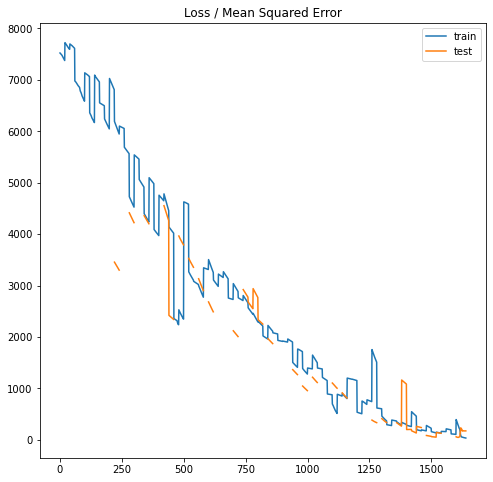

In [13]:
pyplot.figure(figsize=(8,8))
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(hist_df['loss'], label='train')
pyplot.plot(hist_df['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [14]:
test

<MapDataset shapes: ((None, 20, 2), (None, 1, 2)), types: (tf.float64, tf.float64)>

In [15]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4480      
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 4,546
Trainable params: 4,546
Non-trainable params: 0
_________________________________________________________________


In [16]:
window_length = 20

x_test = tf.keras.utils.timeseries_dataset_from_array(
dfs[0][:20], targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)

In [17]:
x_test

<BatchDataset shapes: (None, None, 2), types: tf.float64>

In [20]:
y_pred =lstm_model.predict(x_test)

In [23]:
y_pred

array([[-95.51128,  17.22945]], dtype=float32)

In [27]:
truth = val_df.iloc[21][0], val_df.iloc[21][1]
truth

(-91.14800000000002, 9.519)

In [77]:
lstm_model.save("model.h5")